# Autogluon 설치 + 필요한 모듈 불러오기

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

import lightgbm as lgb

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 확인

In [4]:
df_train = pd.read_csv('train.csv') # 학습용 데이터
df_test = pd.read_csv('submission.csv') # 테스트 데이터(제출파일의 데이터)

In [5]:
## 정제 전
print(df_train.shape, df_test.shape)

(59299, 29) (5271, 30)


In [6]:
## 복제된 행 제거
df_train.drop_duplicates(inplace=True)

# 무조건 converted하면서 test에 없는 회사인 25096은 삭제
del_cus_id=[25096, 47466]
df_train=df_train[~df_train["customer_idx"].isin(del_cus_id)]

In [7]:
## 복제된 행 제거, 25096 제거
print(df_train.shape, df_test.shape)

(46523, 29) (5271, 30)


## 2. 결측치 채우기전 파생변수

### 파생변수 1. bn_submit: band_submit에서 customer_position이랑 expected timeline 작성한 경우 제거


In [8]:
import pandas as pd

# df_train과 df_test를 합친다
df_all = pd.concat([df_train, df_test])
df_all['bn_submit'] = 0

# customer_position이 'none'이 아닌 경우를 체크
condition_position = df_all['customer_position'] != 'none'

df_all["customer_position"]=df_all['customer_position'].replace('none', np.nan)

# expected_timeline이 null이 아닌 경우를 체크
condition_timeline = pd.notnull(df_all['expected_timeline'])

# 조건에 따라 tt 값을 계산
tt = condition_position.astype(int) + condition_timeline.astype(int)

# bn_submit 컬럼 업데이트
df_all['bn_submit'] = df_all['bant_submit'] - (tt / 4)

df_all['customer_position'].replace('none', np.nan)

# df_train과 df_test로 다시 분리
df_train = df_all.iloc[:len(df_train)]
df_test = df_all.iloc[len(df_train):]

df_train = df_train.drop('id', axis=1)

### 파생변수 2. num_missing: 각 행별로 결측치의 개수 count

In [9]:
df_all = pd.concat([df_train, df_test])
df_all['num_missing'] = df_all.isnull().sum(axis=1) - 1

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

## 3. 오타 잡고 묶기

### 3.1. customer_country

In [10]:
## 2. customer_country 오타 제어 함수
def extract_country_name(x):
    if pd.isnull(x):
        return np.nan
    else:
        idx=-1
        a = x.split("/")[idx].strip()
        while a=='':
            idx-=1
            if idx == -4 :
                return 'others'
            a = x.split("/")[idx].strip()
        if idx != -1:
            if a in ['Richmond Hill', 'Vancouver', 'Pickering', 'Winnipeg']:
                return 'Canada'
            elif a in ['ROURKELA', 'Guna mp', 'MADURAI', 'KOLKATA', 'Ahmedabad', 'Madurai'
                       'Mathura', 'Delhi', 'Solan', 'Bengaluru', 'Kanchipuram', 'Erode',
                       'NEARAMBEDKAR HOSPET', 'Bhubaneswar', 'LATEHAR', 'Malur', 'Ackerman',
                       'Faridabad', 'Vasal', 'Ballia', 'Ludhiana', 'Rajkot']:
                return 'India'
            elif a in ['Bergdietikon']:
                return 'Switzerland'
            elif a in ['Lagos, Nigeria', 'Ikoyi', 'Abuja', 'Windhoek']:
                return 'Nigeria'
            elif a in ['Monrovia']:
                return 'Liberia'
            elif a in ['Malvern', 'Cambridge', 'Danbury', 'Dundee', 'Boulder', 'Liverpool', 'Winston']:
                return 'United Kingdom'
            elif a in ['San Jose', 'Bulacan', 'Makati City', 'Manila', 'Cebu', 'Pasig',
                       'CALOOCAN CITY', 'dasmarinas city', 'Mandaluyong City','Angeles' 'makati', 'Angeles City',
                        'Bataan', 'TAYTAY', 'Las Piñas - Muntinlupa', 'Quezon City' ,'Valenzuela City',
                        '314 G. Araneta Ave., Quezon City', 'PASIG CITY', 'Manila', 'San Fernando City, La Union', 'Valenzuela'
                        'CAINTA', 'Quezon City', 'Camarines Sur', 'Mandaluyong', 'San Juan city', 'Qc', 'Meycauayan City, Bulacan',
                        'Parañaque','Rizal', 'Makati city', 'CITY OF IMUS', 'laGrange', 'Sanford', 'Chilhowie', 'Chesterfield', 'Amherst',
                        'Paranaque', 'Cavite', 'CITY OF MARIKINA', 'Bocaue, Bukacan, Philippines']:
                return 'Philippines'

            elif a in ['Atlanta', 'Tbilisi'] :
                return "Georgia"
            elif a in ['Oslo']:
                return 'Norway'
            elif a in ['Arroyo Hondo Viejo'] :
                return 'Dominican Republic'
            elif a in ['Midrand']:
                return 'South Africa'
            elif a in ['Olsztyn', 'Przemysłowa 4, 37-450 Stalowa Wola']:
                return "Poland"
            elif a in ['San Juan']:
                return 'Puerto Rico'
            elif a in ['Berlin', 'Weikersheim', 'Herdwangen-Schönach']:
                return 'Germany'
            elif a in ['Nassau']:
                return 'Bahamas'
            elif a in ['Sapphire', "Mission Hills", 'North Haven', 'Melbourne']:
                return 'Australia'
            elif a in ['Madrid, Spain', 'Madrid', 'Barrio Viejo De Callosa De Segura']:
                return 'Spain'
            elif a in ['Kuwait city'] :
                return 'Kuwait'
            elif a in ['Esch-sur-Alzette']:
                return 'Luxembourg'
            elif a in ['Tashkent']:
                return 'Uzbekistan'
            elif a in ['Taipei city']:
                return 'Taiwan'
            elif a in ['Tokyo']:
                return 'Japan'
            elif a in ['Thai Binh', 'Hai Duong']:
                return 'Vietnam'
            elif a in ['Buengkum']:
                return 'Thailand'
            elif a in ['Gardabaer']:
                return 'Iceland'
            elif a in ['Riyadh', "Makkah", 'Riyadh'] :
                return 'Saudi Arabia'
            elif a in ['Králův Dvůr Levín']:
                return 'Czech Republic'
            elif a in ['Cairo', 'Bloch']:
                return 'Egypt'
            elif a in ['Maseru']:
                return 'Lesotho'
            elif a in ['Colombo 03']:
                return 'Sri Lanka'
            elif a in ["Tirana"]:
                return 'Albania'
            elif a in ['70']:
                return 'others'
            elif a in ['Jakarta'] :
                return 'Indonesia'
            elif a in ['Paramaribo'] :
                return 'Suriname'
            elif a in ['Kampala']:
                return 'Uganda'
            elif a in ['DUBAI', 'Dubai']:
                return 'U.A.E.'
            elif a in ['Paradera']:
                return 'Aruba'
            elif a in ['上海', 'Shenzhen']:
                return 'China'
            elif a in ['Suva']:
                return 'Fiji'
            elif a in ['Budapest']:
                return 'Hungary'
            elif a in ['Amman']:
                return 'Jordan'
            elif a in ['QURUM']:
                return 'Oman'
            else:
                return 'United States'
        if a in ['5555', '48201', 'country', 'A'] :
            return 'others'
        elif '@' in a:
            return 'others'
        else:
            return a


In [11]:
def cus_cty(df) :
  replace_values = {'US' : 'United States',
                    '700 Patroon Creek BlvdAlbanyNY12206' : 'United States',
                    '239 Court St, Brooklyn, NY 11201, United States' : 'United States',
                    'Little Rock, Arkansas, United States' : 'United States',
                    'CA 91915-6002' : 'United States',
                    '430 N Hamilton RdWhitehall, OH 43213, USA' : 'United States',
                    '1110 Morse Rd, Columbus, Ohio, 43229, United States' : 'United States',
                    '1755 North Brown Rd. Suite 200 Lawrenceville, GA 30043' : 'United States',
                    'Miami, Florida, United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '85 W Main St Suite C, Canton, GA 30114' : 'United States',
                    '101 MetLife Way, Cary, NC, 27513 – MET1' : 'United States',
                    '7105 Northland Terrace N, Minneapolis, MN 55428' : 'United States',
                    'CA 95814' : 'United States',
                    '1275 Sister Grove Rd Van Alstyne, TX 75495' : 'United States',
                    '100 Vestavia ParkwayBirminghamAL35216' : 'United States',
                    'CA 92618 United States' : 'United States',
                    'Rio de Janeiro' : 'Brazil',
                    '1605 Ave. Ponce de León, Suite 400 San Juan, 00909, Puerto Rico' : 'Puerto Rico',
                    'IL 60069' : 'United States',
                    '28001 238th St, Le Claire, IA 52753, USA' : 'United States',
                    'Grapevine, Texas, United States United States' : 'United States',
                    '700 District Dr, Itasca, IL 60143 United States' : 'United States',
                    '6398 College Blvd, Overland Park, KS 66211, United States' : 'United States',
                    '3804 W Broadway St, Ardmore, OK 73401, United States' : 'United States',
                    'New York City Metropolitan Area, United States': 'United States',
                    '2529 W Busch Blvd Suite 1000, Tampa, FL 33618, United States' : 'United States',
                    '1100 ITBProvoUT84602' : 'United States',
                    'Telangana' : 'India',
                    'Jeffersonville, IN United States' : 'United States',
                    '6564 Headquarters DrPlanoTX7505' : 'United States',
                    '1817 S Washington AveTitusville, FL 32780, USA' : 'United States',
                    '63 Flushing Ave Bldg 303, Suite 804, Brooklyn, NY 11205, United States' : 'United States',
                    '717 General Booth BlvdVirginia Beach, VA 23451, USA' : 'United States',
                    '2877 Prospect Rd, Fort Lauderdale, FL 33309' : 'United States',
                    'bangalore' : 'India',
                    'MI 48827' : 'United States',
                    '810 N KINGSTON DR PEORIA, IL 61604-2145' : 'United States',
                    'OH 45215, USA' : 'United States',
                    '3801 E Willow St, Long Beach, CA 90815, EE. UU.' : 'United States',
                    'Clinton, OK 73601' : 'United States',
                    'Ha Noi' : 'Vietnam',
                    'ARGENTINA' : 'Argentina',
                    '3100 Shore Drive Virginia Beach, VA 23451' : 'United States',
                    'Los Angeles, California, United States' : 'United States',
                    'West Caldwell NJ 07960 United States' : 'United States',
                    '881 S Division St, Buffalo, NY 14210, United States' : 'United States',
                    '12718 Kitten Trail, Hudson, FL 34669' : 'United States',
                    'FL 33772' : 'United States',
                    '13351 Dovers St, Waverly, NE 68462, United States' : 'United States',
                    'Jacksonville Florida' : 'United States',
                    'Ohio United States' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501' : 'United States',
                    '6564 Headquarters DrPlanoTX75051' : 'United States',
                    'RJ' : 'Brazil',
                    'TX 78572 United States' : 'United States',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119 ' : 'United States',
                    '993 Niagara Ave, San Diego, CA 92107 United States' : 'United States',
                    'Four Embarcadero Center Suite 1400 #85, San Francisco, CA 94111 United States' : 'United States',
                    'odisha' : 'India',
                    'lucknow' : 'India',
                    '1036 n nalder st' : 'United States',
                    'United States 32901' : 'United States',
                    '2100 Engineer Rd, Oakland, CA 94607, United States' : 'United States',
                    'Via E. De Amicis, 23 . 90044 Carini (PA)' : 'Italy',
                    '136 S IndustrialSalineMI48176' : 'United States',
                    '335 League St S, Sulphur Springs, TX 75482' : 'United States',
                    'United States 14503.' : 'United States',
                    'gurgaon' : 'India',
                    '30 Winter Street Boston, MA 02108' : 'United States',
                    '275 John Hancock Rd. Taunton, MA, 02780' : 'United States',
                    'MA 02062 United States' : 'United States',
                    'Pune' : 'India',
                    'FL 33025' : 'United States',
                    'Bari, Italy' : 'Italy',
                    '8 Gay St, Christiana, PA 17509 United States' : 'United States', # 게이 뭐노 ㅋ,
                    '500 N Highway 89 North, Prescott AZ 86313 United States' : 'United States',
                    '609 Medical Center Dr. Decatur, Texas, 76234'  : 'United States',
                    '7703 Floyd Curl Dr MC 7800, San Antonio TX 78229 United States' : 'United States',
                    'St Cloud, MN 56303' : 'United States',
                    '7581 S Franklin Way, Centennial, CO 80122, United States' : 'United States',
                    # '' : 'United States',
                    'Honduras' : 'Honduras',
                    'CARRERA 11A 94-46 EDIFICIO CHICO 3000 PISO 3 BOGOTA' : 'Colombia',
                    'Netherlands Antilles' : 'Netherlands',
                    '823 Gateway Center Way, San Diego, CA 92102' : 'United States',
                    'Colombia  Cartagena' : 'Colombia',
                    'Cuiabá' : 'Brazil',
                    'CO 80127' : 'United States',
                    'TX 75098' : 'United States',
                    'MO 64506' : 'United States',
                    '1222 Eastwick CirMurphy, TX 75094, United States' : 'United States',
                    '545 West 111th st Suite 7C' : 'United States',
                    'P.O. Box 291992, Port Orange, FL 32129' : 'United States',
                    'Isle of Man' : 'United Kingdom', # 아일랜드해안에 있지만, 영국왕국과 결합되어 있다함(사실 별도의 영토는 맞긴한데, 일단 영국으로)
                    'NY 10566 United States' : 'United States',
                    'GA 30039' : 'United States',
                    'Centro de Produção Audiovisual - Sesc São Paulo' : 'Brazil',
                    'Aparecida' : 'Brazil',
                    'Colombia - cartagena' : 'Colombia',
                    'Capão da canoa' : 'Brazil',
                    'São Paulo' : 'Brazil',
                    '1919 Minnesota Ct, Mississauga, ON L5N' : 'Canada',
                    '54 Sugar Creek Center Blvd #300, Sugar Land, TX 77478, United States' : 'United States',
                    'João Pessoa' : 'Brazil',
                    'PerU' : 'Peru',
                    'TN 38120' : 'United States',
                    'Richardson, Texas, United States' : 'United States',
                    'Sao Paulo' : 'Brazil',
                    '2367 N 2650 WFarr WestUT84404' : 'United States',
                    '4880 Stevens Creek BlvdSan JoseCA95129' : 'United States',
                    '3131 BriarPark Dr Suite 200HoustonTX77042' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '450 Riverchase PkwyBirminghamAL35186' : 'United States',
                    '1397 Etowah DriveAtlantaGA30319' : 'United States',
                    '3 Nasson Avenue' : 'United States',
                    'Largo, Florida, United States United States' : 'United States',
                    'FL 33013' : 'United States',
                    'Bucaramanga' : 'Colombia',
                    '7610 Market St, Canton, MI 48187, United States' : 'United States',
                    '116 Village Blvd Suite 200, Princeton, NJ 08540 United States' : 'United States',
                    'Dourados' : 'Brazil',
                    'Foz de Iguaçu - PR Avenida Tancredo Neves 6731 Jardim Itaipu' : 'Brazil',
                    'St Maarten' : 'France', # 프랑스, 네델란드간 분쟁 지역 (프랑스가 더 쌤)
                    'Recife' : 'Brazil',
                    'São Paulo, Pinheiros' : 'Brazil',
                    'Cartagena' : 'Colombia',
                    'Firenze, Italy' : 'Italy',
                    'OR 97128' : 'United States',
                    'Colombia C2: Solo información' : 'Colombia',
                    'Ironhorse Customs LLC 4443 Genella Way North Las Vegas, NV 89031' : 'United States',
                    'San Francisco, CA 94128, United States' : 'United States',
                    '14700 Caribbean Way' : 'United States',
                    'Bus Shed, 6501 Red Hook Rd #201, Nazareth, St Thomas 00802, U.S. Virgin Islands' : 'United States',
                    '1600 Rosecrans Ave bldg 7 ste 101, Manhattan Beach, CA 90266,' : 'United States',
                    'FL 32703' : 'United States',
                    'AGOST, ALICANTE' : 'Spain',
                    'Ohio' : 'United States',
                    'NV 89119' : 'United States',
                    'VA 22209' : 'United States',
                    'NY' : 'United States',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51 ' : 'Greece',
                    'SPAIN ' : 'Spain',
                    'MADRID' : 'Spain',
                    'ELCHE, ALICANTE' : 'Spain',
                    '1800 Congress Ave., Austin, TX 78701' : 'United States',
                    'CA 92657 United States' : 'United States',
                    '9631 Liberty Rd B, Randallstown, MD 21133' : 'United States',
                    'Benbrook, TX 76126' : 'United States',
                    'SC 29555' : 'United States',
                    '6252 E Grant Rd suite 150 Tucson, AZ 85712' : 'United States',
                    'MO 64802 ' : 'United States',
                    'gujarat' : 'India',
                    'IN 46601, EE. UU.' : 'United States',
                    'Warren, OH 44483.' : 'United States',
                    '1 Hoag Dr.' : 'United States',
                    '210 Route 4 East Fl 4' : 'United States',
                    '21903 Ranier Ln' : 'United States',
                    'NY 11358' : 'United States',
                    'CA 95618' : 'United States',
                    'New Hampshire' : 'United States',
                    'GA 31405' : 'United States',
                    'Wyckoff, NJ 07481, USA' : 'United States',
                    '750 Florida Central Parkway Suite #100 Longwood, FL 32750' : 'United States',
                    'FL 33404' : 'United States',
                    '101 Clyde Ave Longwood, FL 32750, USA' : 'United States',
                    'CA' : 'United States',
                    'IL 61615' : 'United States',
                    'Herndon, VA 20170' : 'United States',
                    '724 W Business US Highway 60, Dexter, MO 63841,' : 'United States',
                    'Square at, 2662 Gateway Rd Suite 165, Carlsbad, CA 92009' : 'United States',
                    '1156 W Armitage Ave suite b, Chicago, IL 60614, US.' : 'United States',
                    'MO 63103, USA' : 'United States',
                    'MO 63103' : 'United States',
                    'GRAN CANARIAS PLAYA DEL INGLES' : 'Spain',
                    'CACERES' : 'Spain',
                    '4278 S Buffalo St  Orchard Park, NY 14127' : 'United States',
                    '1775 Liberty Dr, Fort Belvoir, VA 22060, United States' : 'United States',
                    '8569 Sudley Rd Ste C Historic District, Manassas, VA 20110, USA' : 'United States',
                    'MA 02780' : 'United States',
                    'MN 55024' : 'United States',
                    'Delmar, NY 12054 United States' : 'United States',
                    'IL 60638 United States' : 'United States',
                    'MO 64108' : 'United States',
                    'CA 92078' : 'United States',
                    'IL 60563United States' :  'United States',
                    'SD 57751' : 'United States',
                    '990 S Madera Ave, Kerman, CA 93630, United States' : 'United States',
                    '135 Broadway, Schenectady, NY 12305, United States' : 'United States',
                    '1491 Furnace St, Montgomery, AL 36104, United States' : 'United States',
                    '1385 N Weber Rd, Romeoville, IL 60446,' : 'United States',
                    '463 Industrial Park Rd, Elysburg, PA 17824, US' : 'United States',
                    'CA 94555 United States' : 'United States',
                    'UT 84116' : 'United States',
                    '990 Biscayne Dr, Concord, NC 28027, United States' : 'United States',
                    'Nicolosi (CT), Italy' : 'Italy',
                    'FL 33442' : 'United States',
                    'FL 33716' : 'United States',
                    '3440 Rockefeller Ct Waldorf, MD 20602' : 'United States',
                    'Arlington, NY 12603' : 'United States',
                    '65 Grove Street, Suite 204  Watertown, MA 02472' : 'United States',
                    '13854 Lakeside Cir Sterling Heights, MI 48313' : 'United States',
                    '9110 Forest CrossingThe WoodlandsTX77381' : 'United States',
                    'OK 73601 United States' : 'United States',
                    'Hacienda Heights, California, United States' : 'United States',
                    'Connecticut United States' : 'United States',
                    'Caldwell, New Jersey, United States United States' : 'United States',
                    'Gujarat' : 'India',
                    'Chennai' : 'India',
                    'Jamaica, NY 11417, USA' : 'United States',
                    'indore' : 'India',
                    'US Virgin Islands' : 'United Kingdom', # 영국이랑 가까워서 영국으로 해놓음
                    'KS 66217' : 'United States',
                    'NJ 07013' : 'United States',
                    'TX 77024' : 'United States',
                    '30 Cambria Ave, Pleasantville, NJ 08232' : 'United States',
                    '4278 S Buffalo St Orchard Park, NY 14127' : 'United States',
                    '723 S Valley Way, Palmer, AK 99645' : 'United States',
                    'Zip 98433' : 'United States',
                    'bhilwara' : 'India',
                    'ND' : 'United States', # 노스다코타주(미국 도시이름) 줄임말 같음
                    'VT 05672' : 'United States',
                    '800 3rd Ave 3rd floor, New York, NY 10022' : 'United States',
                    'BR' : 'Brazil', # 브라질 iso국가부호
                    'kerela' : 'India',
                    'uttar pradesh' : 'India',
                    'Anand Vihar Delhi' : 'India',
                    'hyderabad' : 'India',
                    "Via dell'informatica 10 - 37036 San Martino Buon Albergo (Veneto), Italy" : ' Italy',
                    'Belo Horizonte' : 'Brazil',
                    '15806 Longship Ct' : 'United States',
                    '2350 Airport FrwyBedfordTX76022' : 'United States',
                    '1999 S Bascomb AveSuite 1000CampbellCA95008' : 'United States',
                    '9716 McFarring DrFort WorthTX76244' : 'United States',
                    '200 cabelLouisvilleKY40206' : 'United States',
                    '1112 Badger Vine LaneArlingtonTX76005' : 'United States',
                    '6111 W Plano Pkwy #2100PlanoTX75093' : 'United States',
                    '100 Sabine River Dr.HuttoTX78634' : 'United States',
                    '6300 Harry Hines BlvdSte. 1400DallasTX75235' : 'United States',
                    '100 first stSan FranciscoCA94015' : 'United States',
                    '899 Kifer RoadSunnyvaleCA94086' : 'United States',
                    '2217 HOUSTON DRIVEMelissaTX75454' : 'United States',
                    '829 Jackson ave' : 'United States',
                    '3027 West Bay Villa Ave' : 'United States',
                    '126 Diablo Ranch Court' : 'United States',
                    '1537 Rolling Hills Dr.' : 'United States',
                    '1715 Forest Cove Drive,  Apt 201' : 'United States',
                    '410 Baylor StAustinTX78703' : 'United States',
                    '9111 cypress waters blvdDallasTX75038' : 'United States',
                    '9420 West Sam Houston Pkwy NHoustonTX77018' : 'United States',
                    '6 Kimball LaneLynnfieldMA1940' : 'United States',
                    '9820 Northcross Center CtHuntersvilleNC28078' : 'United States',
                    '9800 S. Monroe StreetSandyUT84070' : 'United States',
                    '2475 Washington BlvdOgdenUT84401' : 'United States',
                    '400 Centre StNewtonMA2458' : 'United States',
                    '400 Centre StreetNewtonMA2458' : 'United States',
                    '36 Margin StPeabodyMA1960' : 'United States',
                    '77 Massachusetts AveCambridgeMA2139' : 'United States',
                    '160 Gould St Ste 300, Needham Heights, Massachusetts 02494NeedhamMA2721' : 'United States',
                    '9 Landsdowne StreetBostonMA2215' : 'United States',
                    '1209 Derby Run Carrollton, TX 75007CarrolltonTX75007' : 'United States',
                    'One Constitution RoadBostonMA2129' : 'United States',
                    '252 Beech AvenueMelroseMA2176' : 'United States',
                    '5301 Stevens Creek BlvdSanta ClaraCA95051' : 'United States',
                    '230 Highland Ave, Suite 531SomervilleMA2143' : 'United States',
                    '7700 West Sunrise BlvdPlantationFL33322' : 'United States',
                    '602 Saber Creek Drive' : 'United States',
                    '11330 Clay RdHoustonTX77041' : 'United States',
                    '1 Skyview drFort WorthTX76155' : 'United States',
                    '416 Panzano Drive' : 'United States',
                    '5501 Headquarters DrPlanoTX75024' : 'United States',
                    '2266 Palmer Dr.' : 'United States',
                    '1380 Enterprise Dr' : 'United States',
                    '6601 Carroll Highlands Rd' : 'United States',
                    '275 Mishawum Road' : 'United States',
                    '222 Maxine Dr' : 'United States',
                    '2900 Highway 280Suite 250BirminghamAL35223' : 'United States',
                    '305 John Street' : 'United States',
                    'MA 01851' : 'United States',
                    '600 5th Street' : 'United States',
                    'IL 60191' : 'United States',
                    'Cra. 51 #12 sur-75, San Fernando, Itagüi, Medellín, Guayabal, Medellín, Antioquia, Colombia' : 'Colombia',
                    '3000 Montour Church Road' : 'United States',
                    '9820HuntersvilleNC28078' : 'United States',
                    '152 Bowdoin Street' : 'United States',
                    'PO Box 112292CarrolltonTX75011' : 'United States',
                    '825 Eastlake Ave E' : 'United States',
                    '955 Powell Ave SW' : 'United States',
                    '2047  w summerdale ave' : 'United States',
                    '1560 Chance Ct' : 'United States',
                    '8454 Muirwood TrlFort WorthTX76137' : 'United States',
                    '1503 LBJ ParkwaySuite 700Farmers BranchTX75234' : 'United States',
                    '7673 HEMPSTON CIR' : 'United States',
                    '1808 Lithgow RdCelinaTX75009' : 'United States',
                    '1001 Main St' : 'United States',
                    '1909 Forest Knoll DrHooverAL35244' : 'United States',
                    '106 Lakeview DrHomewoodAL35209' : 'United States',
                    '24082 Carmel Dr' : 'United States',
                    '417 20th St NBirminghamAL35203' : 'United States',
                    '594 Howard StSan FranciscoCA94105' : 'United States',
                    '594 Howard StSan FranciscoCA94106' : 'United States',
                    '31700 Temecula Parkway, Temecula CA 92592 United States' : 'United States',
                    '300 East Park Drive' : 'United States',
                    'Manaus' : 'Brazil',
                    'SPAIN' : 'Spain',
                    ', MO 64802' : 'United States',
                    'Columbia' : 'Colombia',
                    'Canda' : 'Canada',
                    'Θέση Πέτσα Βακαλοπούλου ΒΙΟΠΑ Παλλήνης  153 51' : 'Greece',
                    '117 Bernal Rd Ste70-422San JoseSan JoseCA95119' : 'United States',
                    '6005 Commerce Dr. Ste. 300' : 'United States',
                    '17215 Welby Way' : 'United States',
                    '45 n 200 wWillardUT84340' : 'United States',
                    'Swaziland' : 'Switzerland',
                    'Nevada' : 'United States',
                    '1100 Lee Ave, Lafayette, LA 70501,' : 'United States',
                    'MO 64108.' : 'United States',
                    'mumbai' : 'India',
                    'Barranquilla' : 'Colombia',
                    'UAE Dubai' : 'U.A.E.',
                    'COLOMBIA' : 'Colombia',
                    'Türkiye' : 'Turkey',
                    'EGYPT' : ' Egypt',
                    'Democratic Republic of the Congo' : 'Congo',
                    'St Kitts' : 'Saint Kitts and Nevis',
                    'Antigua' : 'Antigua and Barbuda',
                    'Ivory Coast' : "Cote d'Ivoire",
                    'British Virgin Islands' : 'United Kingdom',
                    '85 W Main St Suite C, Canton, GA 30114,' : 'United States',
                    'Turks and Caicos Islands' : 'United Kingdom',
                    'VALENCIA' : 'Spain',
                    'Dominican republic': 'Dominican Republic',
                    'UNITED STATES': 'United States',
                    'NE' : 'United States',
                    'FL' : 'United States',
                    'TX' : 'United States',
                    'NJ' : 'United States',
                    'NIM' : 'United States',
                    'NM' : 'United States',
                    'Englewood, CO' : 'United States',
                    'W126 N7449 Flint Drive Menomonee Falls VA' : 'United States',
                    '3 Center Plz Suite 330 Boston, MA 02108' : 'United States',
                    'Curaçao': 'Netherlands',
                    '5003 Lady Of The Lake Dr  Raleigh NC': 'United States',
                    '233 South Beaudry Avenue  Los Angeles CA': 'United States',
                    '603 Heritage Drive  Mount Juliet': 'United States',
                    'Sandford': 'United Kingdom',
                    'BLOOMSBURY': 'United Kingdom',
                    'Southfield': 'United States',
                    'Indianapolis': 'United States',
                    'maharashtra': 'India',
                    'Salt Lake City': 'United States',
                    'New York': 'United States',
                    'Soufriere': 'Saint Lucia',
                    'Mumbai': 'India',
                    'San Diego': 'United States',
                    'Batavia': 'Indonesia',
                    'Bangalore': 'India',
                    'Houston': 'United States',
                    }

  df['customer_country'] = df['customer_country'].replace(replace_values)
  return df

In [12]:
## 2. customer_country
df_train["customer_country"] = df_train["customer_country"].apply(extract_country_name)
df_test["customer_country"] = df_test["customer_country"].apply(extract_country_name)

df_train = cus_cty(df_train)
df_test = cus_cty(df_test)

In [13]:
# df_country 결측치 채우기 -> 담당 자사 법인명 기준으로 많이 의뢰한 국가로 채워보자
df_all = pd.concat([df_train, df_test])
df_c = df_all.groupby(['response_corporate', 'customer_country'])["is_converted"].count().reset_index()

def get_max_group(group):
    max_row = group.loc[group['is_converted'].idxmax()]
    return max_row['customer_country']

result = df_c.groupby('response_corporate').apply(get_max_group)

zero_indices = df_train.index[df_train['customer_country']==0]
for index in zero_indices:
    df_train.loc[index, 'customer_country']=result[df_train.loc[index, "response_corporate"]]
zero_indices = df_test.index[df_test['customer_country']==0]
for index in zero_indices:
    df_test.loc[index, 'customer_country']=result[df_test.loc[index, "response_corporate"]]

### 3.2 custoer_position

In [14]:
def position_refine(df):
    replace_words={
        'other': 'other',
        'this is a consume display requirement for home purpose.':'other',
        'vicepresident': 'vice president',
        'bulgaria' : 'other',
        'lider de desarrollo': 'ceo/founder',
        'decision-influencer': 'ceo/founder',
        'decision-maker': 'ceo/founder',
        'architecture/consult' : 'architect/consultant',
        'software /solution provider' :  'software/solution provider',
        'vp' : 'vice president',
        'prof.' : 'professor',
        'pgt Physcis': "post graduate teacher in physics",
        'asst prof.': 'assistant professor',
        'ceo/fundador': 'ceo/founder',
        'gerente': 'manager',
        'tierarzt': 'veterinarian',
        'técnico' : 'technician',
        'exhibitiontv' : 'other',
        'proprietário(a)' : 'owner',
        'genel müdür' : 'ceo/founder',
        'mindenes' : 'other',
        'főorvos' : 'chief physician',
        'surgery professional' : 'surgeon',
        'research': 'researcher',
        'the big boss': 'ceo/founder',
        'radiology professional' : 'radiologist',
        'associate professor in electornics engg': 'associate professor',
        'assistant professor of enlish': 'assistant professor',
        'consulting': 'consultant',
        'education': 'educator',
        'education professional': 'educator',
        'english trainer for ielts,toefl,pte,gre,sat exams.' : 'english trainer',
        'entrylevel': 'entry level',
        'exhibitiontv': 'exhibitiontv',
        'founder': 'ceo/founder',
        'no influence': 'other',
        'c-levelexecutive': 'c-level executive',
        'others': 'other',
        'none': 'other',
    ## 상위 10개로 분류
        'leader': 'ceo/founder',
        'av management': 'manager',
        'business partner': 'partner',
        'business unit director': 'director',
        'chairman': 'manager',
        'chief executive officer': 'ceo/founder',
        'commercial end-user': 'end-user',
        'decision influencer': 'ceo/founder',
        'decision maker' : 'leader',
        'leadership/executive office/owner': 'ceo/founder',
        'market intelligence/research': 'associate/analyst',
        'owner': 'ceo/founder',
        'principal & director': 'director',
        'product management': 'manager',
        'intern': 'trainee'
    }

    df['customer_position'].replace(replace_words, inplace=True)

    return df

In [15]:
df_train = position_refine(df_train)
df_test = position_refine(df_test)

In [16]:
def preprocess_customer_position(df):

    top10_positions = df['customer_position'].value_counts().index[:10]

    df['customer_position'] = df['customer_position'].apply(lambda x: x if x in top10_positions and pd.notnull(x) else 'other')

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_position(df_train)
df_test = preprocess_customer_position(df_test)

In [17]:
df_train['customer_position'].value_counts()

customer_position
other                20080
manager               7121
ceo/founder           6785
director              3904
associate/analyst     2266
partner               2187
entry level           1968
trainee               1066
c-level executive      720
end-user               426
Name: count, dtype: int64

In [18]:
df_test['customer_position'].value_counts()

customer_position
other                2633
manager               726
ceo/founder           593
director              343
associate/analyst     279
entry level           225
partner               224
trainee               109
c-level executive      85
vice president         54
Name: count, dtype: int64

### 3.3 customer_type

In [19]:
def cus_type_typo(df) :

  #  == 오타 먼저 전처리 ==
  replace_values_typo = {
      'End-Customer' : 'End Customer',
      'Other' : 'Others',
      'Etc.' : 'Others',
      'End-user' : 'End Customer',
      'Specifier / Influencer' : 'Specifier/ Influencer',
      'Home Owner' : 'Homeowner',
      'Corporate' : 'Installer/Contractor',
      'Software / Solution Provider' : 'Software/Solution Provider',
  }

  # == 대체하기 ==
  replace_values =  {
      'Solution Eco-Partner' : 'Service Partner',
      'Engineer' : 'Specifier/ Influencer',
      'HVAC Engineer' : 'Specifier/ Influencer',
      'Technician' : 'Specifier/ Influencer',
      'Consultant' : 'Service Partner',
      'Developer' : 'Specifier/ Influencer',
      'Homeowner' : 'End Customer',
      'Software/Solution Provider' : 'Service Partner', # 종합적인 solution을 제공한다고 생각하여 SP
      'Software / Solution Provider' : 'Service Partner', #
      'Manager / Director' : 'Specifier/ Influencer',
      'Installer' : 'Channel Partner', # 설치업자는 현장 설치를 전문적으로 수행한다고 생각함
      'Installer/Contractor' : 'Channel Partner',
      'Architect/Consultant' : 'Service Partner',
      'Distributor' : 'Channel Partner',
      'Reseller' : 'Channel Partner',
      'Dealer/Distributor' : 'Channel Partner',
      'System Integrator' : 'Service Partner',
      'Technical Assistant' : 'Service Partner',
      'Commercial end-user' : 'End Customer',
      'Administrator' : 'Channel Partner',
      'Interior Designer' : 'Specifier/ Influencer'
  }
  df['customer_type'] = df['customer_type'].replace(replace_values_typo)
  df['customer_type'] = df['customer_type'].replace(replace_values)

  # 결측치 처리

  return df

df_train = cus_type_typo(df_train)
df_test = cus_type_typo(df_test)

In [20]:
df_train['customer_type'].value_counts()

customer_type
End Customer             8593
Specifier/ Influencer    2438
Channel Partner          1358
Service Partner           472
Others                     20
Name: count, dtype: int64

In [21]:
df_test['customer_type'].value_counts()

customer_type
End Customer             2454
Specifier/ Influencer     789
Channel Partner           327
Service Partner           244
Name: count, dtype: int64

### 3.4 customer_job

In [22]:
def cus_job_typo(df):

  # == 오타 먼저 전처리 ==
  replace_values = {
      'graphic/color art' : 'arts and design',
      '3d/vfx art' : 'arts and design',
      'clinical specialist' : 'healthcare services',
      'radiology professional' : 'healthcare services',
      'medical imaging specialist' : 'engineering',
      'surgery professional' : 'healthcare services',
      'pathologist' : 'healthcare services',
      'art and design' : 'arts and design',
      'programm-_und_projektmanagement' : 'program and project management',
      'engineering & technical' : 'engineering',
      'technical' : 'engineering',
      'medien_und_kommunikation' : 'media and communication',
      'finanzen' : 'finance',
      'designer' : 'arts and design',
      'information_technology' : 'information technology',
      'kreation_und_design' : 'arts and design',
      'sonstiges' : 'other',
      'arts_and_design' : 'arts and design',
      'otro' : 'other',
      'computing & it' : 'information technology',
      'it director' : 'information technology',
      'engineer' : 'engineering',
      'program_and_project_management' : 'program and project management',
      'surgery professional' : 'healthcare services',
      'clinic' : 'healthcare services',
      'projektmenedzsment\tprogram and project management' : 'program and project management',
      'information technology​' : 'information technology',
      'it' : 'information technology',
      'healthcare_services' : 'healthcare services',
      'amministrativo' : 'administrative',
      'surgery professional​' : 'healthcare services',
      'adminisztráció' : 'administrative',
      'pénzügy' : 'finance',
      'radiology  professional' : 'healthcare services',
      'healthcare professionals' : 'healthcare services',
      'it - information technology' : 'information technology',
      'engineering & technical executive' : 'engineering',
      'program_and_project_manager' : 'program and project management',
      'administration' : 'administrative',
      'tech' : 'engineering',
      'it/software' : 'information technology',
      'arte_e_design' : 'arts and design',
      'program-_és_projektmenedzsment' : 'program and project management',
      'others' : 'other',
      'medical solution provider' : 'engineering',
      'owner' : 'entrepreneurship',
      'manager' : 'product management',
      'project manager' : 'program and project management',
      'curation' : 'arts and design',
      'quality assurance' : 'engineering',
      'general management' : 'business development',
      'architect' : 'engineering',
      'gm' : 'business development',
      'decision maker' : 'business development',
      'ceo' : 'entrepreneurship',
      'lead' : 'entrepreneurship',
      'director' : 'business development',
      'purchaser' : 'purchasing',
      'buyer' : 'purchasing',
      'arquitecto/consultor' : 'consulting',
      'executive' : 'entrepreneurship',
      'vertrieb' : 'marketing',
      'ceo/founder' : 'entrepreneurship',
      'general manager' : 'operations',
      'arquitecto/consultor' : 'consulting',
      'military and protective services' : 'other',
      'community_and_social_services' : 'other',
      'installer' : 'operations',
      'consultant' : 'consulting',
      'revendedor' : 'sales',
      'research & development' : 'research',
      'procurement' : 'operations',
      'coordinator' : 'entrepreneurship',
      'integrador' : 'operations',
      'integrator' : 'operations',
      'operations manager ' : 'operations',
      'it manager' : 'information technology',
      'advertising' : 'marketing',
      'chief engineer' : 'engineering',
      'business_development' : 'business development',
      'project coordinator' : 'program and project management',
      'vendite' : 'sales',
      'medical solution  provider' : 'healthcare services',
      'media_e_comunicazione' : 'media and communication',
      'egyéb' : 'other',
      'pm' : 'program and project management',
      'account management' : 'accounting',
      'quality_assurance' : 'sales',
      'associate/analyst' : 'finance',
      'general contractor' : 'operations',
      'contractor' : 'operations',
      'reseller' : 'sales',
      'institute & academy' :  'education',
      'other stores' : 'other',
      'educator' : 'education',
      'distributor' : 'sales',
      'medical imaging  specialist' : 'engineering',
      'sales manager' : 'sales',
      'purchasing agent' : 'purchasing',
      'művészet_és_design' : 'arts and design',
      'av tech' : 'information technology',
      'administrative assistant' : 'administrative',
      'média_és_kommunikáció' : 'media and communication',
      'sales manager' : 'product management',
      'purchase' : 'purchasing',
      'sales operations' : 'sales',
      'procurement specialist' : 'purchasing',
      'distribuidor' : 'sales',
      'marketing executive' : 'marketing',
      'coo' : 'entrepreneurship',
      'field marketing' : 'marketing',
      'vice president' : 'other',
      'technical director' : 'engineering',
      'planner' : 'operations',
      'producer' : 'product management',
      'product marketing' : 'marketing',
      'project architect' : 'engineering',
      'operations executive' : 'operations',
      'operations manager' : 'operations',
      'higher education (college & university)' : 'education',
      'director of it' : 'information technology',
      'design' : 'arts and design',
      'project lead' : 'program and project management',
      'recommend (you recommend specific products or technologies for the solution)' : 'consulting',
      'project head' : 'program and project management',
      'medios_de_comunicación' : 'media and communication',
      'sales executive' : 'sales',
      'solution provider'  : 'consulting',
      'üzemeltetés' : 'operations',
      'értékesítés' : 'sales',
      'influencer' : 'marketing',
      'interior designer' : 'arts and design',
      'leader' : 'entrepreneurship',
      'implement' : 'operations',
      # 'hr' : '' 보류
      'marketing operations' : 'operations',
      'following up' : 'sales',
      'supervisor' : 'operations',
      'management' : 'program and project management',
      'user' : 'sales',
      'cliente final' : 'sales',
      'president' : 'other',
      'event marketing' : 'marketing',
      'collaboration & web apps' : 'information technology',
      'sales engineering' : 'engineering',
      'estimator' : 'engineering',
      'end user' : 'sales',
      'altro' : 'other',
      'project director' : 'program and project management',
      'admin' : 'administrative',
      'technical marketing' : 'marketing',
      'railway & metro station' : 'operations',
      'graphic design' : 'arts and design',
      'fashion' : 'arts and design',
      'account exec/manager' : 'accounting',
      'purchasing manager' : 'purchasing',
      'details send' : 'operations',
      'pacs administrator' : 'healthcare services',
      'it specialist' : 'information technology',
      'autres' : 'other',
      'electronics & telco' : 'engineering',
      'medical solution provider' : 'healthcare services',
      'emerging technology / innovation' : 'engineering',
      'infrastructure' : 'operations',
      'designer/ project manager' : 'other', # 너무 애매함
      'restaurant display' : 'other',
      'test4' : 'other',
      'energy' : 'engineering',
      'broadcasting & media' : 'media and communication',
      'systems administrator' : 'administrative',
      'customer experience' : 'other',
      'field / outside sales' : 'sales',
      'sourcing / procurement' : 'operations',
      'chief of engineering' : 'engineering',
      'designers' : 'arts and design',
      'design/build' : 'arts and design',
      'it hardware technician ' : 'engineering',
      'electrical contractor' : 'operations',
      'systems design' : 'arts and design',
      'it admin' : 'information technology',
      'property owner' : 'real estate',
      'menu' : 'other',
      'sme' : 'entrepreneurship',
      'design/install/training/support' : 'arts and design',
      'electronics evaluator' : 'operations',
      'assist in serving food' : 'support',
      'underboss' : 'entrepreneurship',
      'community theater' : 'support',
      'cintractor' : 'operations',
      'it support' : 'information technology',
      'building owner' : 'real estate',
      'teacher' : 'education',
      'it project lead' : 'information technology',
      'hardware design engineer' : 'engineering',
      'it dairector' : 'information technology',
      'designer/ engineer' : 'other',  # 경계 모호
      'design and install' : 'arts and design',
      'designer, creative technologist' : 'arts and design',
      'primary end-user' : 'sales',
      'it department' : 'information technology',
      'designer/installer' : 'arts and design',
      'medical solution provider​' : 'healthcare services',
      'photographer' : 'arts and design',
      'no respoxse on phone will try again ' : 'other',
      'product_management' : 'product management',
      'solution engineer' : 'engineering',
      'reseller/integrator' : 'sales',
      'facilitator installation services' : 'operations',
      'display' : 'engineering',
      'media and communications' : 'media and communication',
      'av project manager' : 'program and project management',
      'otros' : 'other',
      'architect ass interiores' : 'arts and design',
      'requirement close' : 'other',
      'system designer, integrator' : 'arts and design',
      'no requirment' : 'other',
      'corporate / office' : 'entrepreneurship',
      'colorist' : 'arts and design',
      'engineering, design, and install' : 'other',  # 경계 모호
      'software solution' : 'consulting',
      'serving food' : 'support',
      'doctor' : 'healthcare services',
      'manufacturing factory / plant' : 'operations',
      'waiter' : 'support',
      'chief' : 'entrepreneurship',
      'contributor' : 'support',
      'purchsing' : 'purchasing',
      'chef' : 'other',
      'designer purchaser' : 'arts and design',
      'authorize (you are responsible for making the final decision)' : 'business development',
      'a/v project manager' : 'program and project management',
      'final approval' : 'other',
      'design engineer' : 'arts and design',
      'inquiry-to-buy/contact-us test' : 'operations',
      'director of lodging' : 'operations',
      'lead engineer' : 'engineering',
      'design/purchaser' : 'other', # 경계 모호
      'technology consultant' : 'consulting',
      'project manager/designer' : 'program and project management',
      'no respoxse on phone will try again' : 'other',
      'consultent' : 'consulting',
      'elevator company' : 'entrepreneurship',
      'for confrence' : 'operations',
      'distributor quotation' : 'operations',
      'quoting project' : 'administrative',
      'manger' : 'product management', # 임의로 넣어둠
      'design consultant' : 'consulting',
      'project engineer' : 'engineering',
      'conference room' : 'other',
      'it hardware technician' : 'information technology',
      'designer/pm/gc' : 'other',
      'furnish and install' : 'other',
      'videowall' : 'other',
      'it tech.' : 'information technology',
      'projectr mgmt' : 'program and project management',
      'facility administrator' : 'administrative',
      'software developer' : 'information technology',
      'principal' : 'education',
      'home theater' : 'other',
      'team lead' : 'program and project management',
      'serving robot' : 'operations',
      'nothing' : 'other',
      'cctv view' : 'operations',
      'product researcher' : 'research',
      'purchase dept' : 'sales',
      'instructor' : 'education',
      'decider' : 'business development',
      'seller installer' : 'sales',
      'general manager (decision maker)' : 'business development',
      'procurment' : 'operations',
      'f&b director for bicycle casino' : 'other',
      'supplier and installation ' : 'sales',
      'managing director' : 'program and project management',
      'sales rep' : 'sales',
      'installer/sales rep' : 'sales',
      'cctv monetoring' : 'operations',
      'department secretary' : 'administrative',
      'r&d project manager' : 'program and project management',
      'facilities and operations' : 'operations',
      'component of video wall' : 'other',
      'systems engineer' : 'engineering',
      'installer.' : 'operations',
      'principal in charge' : 'program and project management',
      'fixing tv' : 'other',
      'director of engineering' : 'engineering',
      'regional director of operations' : 'operations',
      'chief eng.' : 'engineering',
      'supplier and installation' : 'entrepreneurship',
      'sale' : 'sales',
      'installation and purchaser' : 'purchasing',
      'maintenance technician' : 'engineering',
      'purchasing supervisor' : 'consulting',
      'we are in iceland' : 'other', # 뭐냐이건 ㅋㅋㅋㅋㅋ
      'part of video wall' : 'other',
      'mental health' : 'healthcare services',
      'technical / decision maker' : 'operations',
      'ops mgr' : 'operations',
      'research products and prices' : 'research',
      'for presentations' : 'other',
      'managing partner' : 'program and project management',
      'store promotions' : 'marketing',
      'owner / project manager' : 'other',  # 경계 모호
      'installer/ system integrater' : 'operations',
      'office it' : 'entrepreneurship',
      'principal engineer ' : 'engineering',
      'tradeshow event' : 'marketing',
      'serving ' : 'support',
      'deputy cio' : 'entrepreneurship',
      'project manage' : 'program and project management',
      'recommender' : 'other',
      'resource manager' : 'product management',
      'display screen from control' : 'other',
      'general manager - project manager' : 'program and project management',
      'sourcing/procurement' : 'operations',
      'parts coordinator' : 'support',
      'accounts payable' : 'sales',
      'main end user of the product' : 'product management',
      'ranger 2 ' : 'other',
      'pricing ' : 'sales',
      'purchasers' : 'purchasing',
      'av estimator' : 'sales',
      'appliance specialist' : 'consulting',
      'consultant,cabinet fabricator' : 'other', # 경계 모호
      'director of operations' : 'operations',
      'construction manager' : 'program and project management',
      'research and developement' : 'research',
      'imaging administrator' : 'administrative',
      'design/decision maker' : 'operations',
      'signage manager' : 'product management',
      'planning and installation' : 'operations',
      'network administrator' : 'administrative',
      'reseorot general manager' : 'program and project management',
      'correspondence' : 'other',
      'director of finance' : 'finance',
      'intergrator' : 'other',
      'quote gathering/proposer to owner' : 'sales',
      'owner representation' : 'real estate',
      'digital display vs signage need' : 'other',
      'principal engineer' : 'engineering',
      'technical sales' : 'sales',
      'producer/project manager' : 'program and project management',
      'submitting proposal' : 'operations',
      'program directors' : 'program and project management',
      'costar av team' : 'real estate',
      'conference table' : 'other',
      'serving' : 'other',
      'genera manager' : 'business development',
      'hardware' : 'engineering',
      'repair uhd 120 hz units' : 'support',
      'recommendation' : 'other',
      'equipment and app provider' : 'information technology',
      'ranger 2' : 'other',
      'pricing ' : 'sales',
      'project researcher' : 'research',
      'post install support and service' : 'support',
      'sign company' : 'entrepreneurship',
      'content creation, eq consultant' : 'consulting',
      'buyer, coordinating' : 'purchasing',
      'project designer' : 'program and project management',
      'cloud / mobility' : 'information technology',
      'teaching' : 'education',
      'equipment planner' : 'purchasing',
      'interior stylist' : 'arts and design',
      'project sales/manage' : 'sales',
      'master mind' : 'entrepreneurship',
      'quotation curator' : 'arts and design',
      'service coordinator' : 'entrepreneurship',
      'creative director' : 'arts and design',
      'tester' : 'operations',
      'studio manager' : 'program and project management',
      'purchase and install' : 'operations',
      'asking for quote for client' : 'other',
      'general manager- purchaser' : 'other', # 경계 모호
      'purchasing authority' : 'purchasing',
      'product research' : 'research',
      'pricing' : 'sales',
      'salesman' : 'sales',
      'hotel manager' : 'operations',
      'var' : 'sales',
      'sho lyrics' : 'other',
      'hardware selection' : 'engineering',
      'it administrator' : 'information technology',
      'replacement tv' : 'other',
      'platform administrator' : 'administrative',
      'drop, purchase maxhub' : 'other',
      'asset management' : 'accounting',
      'digital signage' : 'other',
      'solution advisor' : 'consulting',
      'purchasing director' : 'purchasing',
      'facilities' : 'other',
      'federal government contractor' : 'other',
      'stakeholder' : 'program and project management',
      'sourcing & quoting for end user' : 'sales',
      'integration' : 'operations',
      'contractor/owner' : 'real estate',
      'advertising and promotions team' : 'marketing',
      'sourcing' : 'administrative',
      'photos' : 'arts and design',
      'facility manager' : 'program and project management',
      'project manager / principal' : 'program and project management',
      'managing contractor' : 'program and project management',
      'signage subcontractor p/m' : 'product management',
      'solutions provider and specifier' : 'consulting',
      'informatics, touch capability' : 'other',
      'guestroom tv' : 'other',
      'application development' : 'information technology',
      'developer' : 'information technology',
      'profesional de cirugía' : 'healthcare services',
      'spécialiste_en_imagerie_médicale' : 'healthcare services',
      'chirurgien' : 'healthcare services',
      'cirugano' : 'healthcare services',
      'media_and_communication' : 'media and communication',
      'tierarzt' : 'media and communication',
      'digital project manager' : 'program and project management',
      'entry level' : 'other',
      'si' : 'other',
      'director comercial' : 'sales',
      'car dealership' : 'sales',
      'proprietário(a)' : 'real estate',
      'genel müdür' : 'program and project management',
      'mindenes' : 'other', # 만능인 ㅇㅈㄹ
      'főorvos' : 'healthcare services',
      'intern' : 'other',
      'the big boss' : 'entrepreneurship',
      'strategic communications' : 'program and project management',
      'renewable energy' : 'engineering',
      'museum / gallery' : 'arts and design',
      'profesional de radiología' : 'healthcare services',
      'military_and_protective_services ' : 'other',
      'project administrator' : 'program and project management',
      'radiology_professional' : 'healthcare services',
      'signage for an attraction' : 'other',
      'equipment selection' : 'other',
      'system engineer' : 'engineering',
      'designere / budget' : 'arts and design',
      'n.a' : 'other',
      'commander' : 'other',
      'enterprise resource planning' : 'administrative',
      'help desk / desktop services' : 'support',
      'finance executive' : 'finance',
      'senior design engineer' : 'engineering',
      'directeur technique' : 'program and project management',
      'c-level executive' : 'entrepreneurship',
      'programm- und projektmanagement' : 'program and project management',
      'kreation und design' : 'arts and design',
      'operaciones' : 'operations',
      'administración' : 'administrative',
      'gestión_de_proyectos' : 'program and project management',
      'finanzas' : 'finance',
      'arte y diseño' : 'arts and design',
      'investigator' : 'administrative',
      'marketing coordinator' : 'marketing',
      'vendor / reseller' : 'sales',
      'maintenance supervisor' : 'consulting',
      'head of technology' : 'engineering',
      'sliding pictures of beauty salon' : 'other',
      'gm/part owner' : 'program and project management',
      'project manager / estimator' : 'program and project management',
      'managing employee' : 'entrepreneurship',
      'designer, producer' : 'other',
      'display our products' : 'other',
      'lead designer' : 'arts and design',
      'architect/owner' : 'other',
      'planner/purchaser' : 'other',
      'global lead of production' : 'product management',
      'liason' : 'other',
      'maintenance' : 'product management',
      'product owner' : 'product management',
      'helpdesk specialist' : 'support',
      'the person with the credit card' : 'other',
      'projection manager' : 'program and project management',
      'need one tv' : 'other',
      'gc' : 'entrepreneurship',
      'ownner-marketing director' : 'marketing',
      'hotel tv' : 'other',
      'video wall' : 'other',
      'managgere' : 'program and project management',
      'engagement executive' : 'entrepreneurship',
      'military_and_protective_services ' : 'other',
      'solutions architect' : 'consulting',
      'project team member' : 'program and project management',
      'director purchaser' : 'purchasing',
      'head' : 'entrepreneurship',
      'reviewer' : 'marketing',
      'admin assistant' : 'administrative',
      'development coordinator/procurement' : 'operations',
      'ordering manager' : 'program and project management',
      'facilitator' : 'program and project management',
      'sub contractor' : 'operations',
      'primary' : 'entrepreneurship',
      'retailer/installer' : 'purchasing',
      '5% of hotel needs' : 'other',
      'av technician' : 'engineering',
      'overseer' : 'program and project management',
      'business owner' : 'business development',
      'display screen' : 'other',
      'obtain quotes, process purchase' : 'other',
      'tv studio manager' : 'program and project management',
      'purchasing coordinator' : 'other',
      'it integrator' : 'information technology',
      'design and installation company' : 'entrepreneurship',
      'replacing tv' : 'support',
      'manufacturer' : 'other',
      'art installation' : 'arts and design',
      'support/facilitator, designer' :  'other',
      'supplier' : 'sales',
      'design and provide equipment' : 'arts and design',
      'director,it' : 'information technology',
      'team leader' : 'program and project management',
      'purchaser, it and installer' : 'other',
      'need 1 tv 55" edge led 4k uhd' : 'other',
      'site manager' : 'program and project management',
      "i'm directing it" : 'information technology',
      'military_and_protective_services' : 'other',
      'strategy & operations specialist' : 'operations',
      'change tv' : 'support',
      'wall mounted screen mirroring' : 'other',
      'organizer' : 'entrepreneurship',
      'using for window display' : 'other',
      'project facilitator' : 'program and project management',
      'equipment custodian' : 'product management',
      'comanager' : 'program and project management',
      'tech service' : 'support',
      'requisition' : 'sales',
      'engineering director' : 'engineering',
      'testing and troubleshooting' : 'other',
      'office manager' : 'other',
      'requirements and buyer' : 'purchasing',
      'research and instalaltion' : 'research',
      'vp/gm' : 'other',
      'technology designer' : 'arts and design',
      'systems designer' : 'arts and design',
      'artist, lead on equipment selection' : 'arts and design',
      'owning company' : 'entrepreneurship',
      'execution' : 'other',
      'director it' : 'information technology',
      'research' : 'research',
      'hr' : 'administrative',
      'human resources' : 'administrative',
      'hr posting' : 'administrative',
      'human_resources' : 'administrative',
      'healthcare': 'healthcare services'
  }

  # == 대체하기 ==
  df['customer_job'] = df['customer_job'].replace(replace_values)

  # 결측치는 unknown
  counts = df['customer_job'].value_counts()
  df['customer_job'] = df['customer_job'].apply(lambda x: 'other' if pd.notnull(x) and counts[x] == 1 else x)

  return df

df_train = cus_job_typo(df_train)
df_test = cus_job_typo(df_test)

In [23]:
def preprocess_customer_job(df):

    top15_jobs = df['customer_job'].value_counts().index[:15]

    df['customer_job'] = df['customer_job'].apply(lambda x: x if x in top15_jobs and pd.notnull(x) else 'other')

    return df

# 함수를 훈련 데이터와 테스트 데이터에 적용
df_train = preprocess_customer_job(df_train)
df_test = preprocess_customer_job(df_test)

In [24]:
df_train['customer_job'].value_counts()

customer_job
other                             18189
engineering                        5995
administrative                     3212
education                          2177
sales                              2104
operations                         1894
arts and design                    1865
purchasing                         1778
information technology             1756
business development               1707
healthcare services                1313
consulting                         1258
entrepreneurship                   1229
marketing                          1050
program and project management      996
Name: count, dtype: int64

In [25]:
df_test['customer_job'].value_counts()

customer_job
other                             2237
engineering                        737
education                          408
administrative                     321
information technology             231
operations                         195
purchasing                         180
consulting                         166
business development               164
sales                              162
entrepreneurship                   119
arts and design                    107
program and project management      96
marketing                           94
healthcare services                 54
Name: count, dtype: int64

### 3.5 product_category

In [26]:
replace_pc_words={
    'etc.': 'others',
    'other': 'others',
    'noteboook': 'laptop',
    'teto ou cassete inverter': 'ventilation',
    'all lg vrf systems' : 'vrf',
    'residential air conditioner': 'rac',
    'חימום': 'heating',
    'idb': 'interactive signage',
    'video wall': 'video wall signage',
    'lg one:quick': 'one:quick series',
    'aio | one quick': 'one:quick series',
    'high brightness': 'high brightness signage',
    '43us660h0sd.awz': 'hotel tv',
    'fhd series': 'commercial tv',
    'led 顯示屏': 'led signage',
    '酒店電視': 'hotel tv',
    'one:quick flex': 'one:quick series',
    'ultra stretch series': 'digital signage',
    'tv signage': 'commercial tv',
    'collaboration displays': 'digital signage',
    'oled 顯示屏': 'oled signage',
    'meeting & screen sharedirect view leddirect view led': 'led signage',
    'window facing display': 'digital signage',
    'lg customer care program': 'others',
    'led': 'led signage',
    'pendingin': 'heating',
    'cmulti v 5 air': 'heating',
    'ar condicionado residencial' : 'rac',
    'مبرد (تشيلر)': 'heating',
    'multi v water 5': 'heating',
    'single split': 'single-split',
    'ahu': 'ventilation',
    'multi split': 'multi-split',
    'lainnya': 'others',
    'lg home bliss air solution': 'ventilation',
    'lg paradise air solution': 'ventilation',
    'isıtma': 'heating',
    'تكييفات': 'multi-split',
    'פיצול מרובה': 'multi-split',
    'تكييف وتبريد': 'heating',
    'אחר': 'others',
    'vrf,multi-split': 'vrf',
    'vrf,multi-split,chiller': 'vrf',
    'vrf,multi-split,single-split,chiller,heatin': 'vrf',
    '28mq780': 'monitor',
    'computer monitor': 'monitor',
    'monitor & pc': 'monitor',
    'medical monitor': 'medical display',
    'videwall': 'video wall signage',
    'ultra stretch signage': 'digital signage',
    'digital signage or commercial tvs': 'digital signage',
    'onequick series': 'one:quick series',
    'education createboard': 'digital signage',
    'virtual production': 'others',
    'laec015': 'led signage',
    '55us660h0sd.bwz': 'commercial tv',
    'transparent oled': 'oled signage',
    'medical- surgical': 'medical display',
    'radiology displays': 'medical display',
    'high inch 86 / 98 or 110': 'digital signage',
    'leadallin': 'led signage',
    'ฯลฯ': 'others',
    'taa lcd lfd displays': 'digital signage',
    'rac/cac': 'rac',
    'حلول التدفئة': 'heating',
    'otros': 'others',
    'sac': 'heating',
    'laec015-gn.awz': 'led signage',
    'gscd046' : 'led signage',
    '32lq621cbsb.awz': 'commercial tv',
    '43uh5f-h.awzm': 'commercial tv',
    '49vl5g-m.awzm': 'commercial tv',
    '55uq801c0sb.bwz': 'commercial tv',
    'tv': 'commercial tv',
    '43uq751c0sf.bwz': 'commercial tv',
    '32 / 43 pol': 'commercial tv',
    'htv': 'commercial tv',
    '43uq751c0sb.bwz': 'commercial tv',
    '49uh / 49xf': 'commercial tv',
    '50us660h0sd.bwz': 'commercial tv',
    'tv 60"': 'commercial tv',
    'medical monitor': 'medical display',
    'unitario':'single-split',
    'cac': 'ventilation',
    'vrf,chiller': 'vrf',
    'single package': "single-split",
    'điều hòa trung tâm multi': 'multi-split',
    'ogrzewanie (pompy ciepła)': 'heating',
    'soğutucu': 'heating',
    'điều hòa gia dụng': 'rac',
    'نظام التدفق المتغيرvrf': 'vrf',
    'chiller/enfriadoras': 'chiller',
    '49vl5g-m': 'digital signage',
    'lg led bloc': 'led signage',
    'uh': 'commercial tv',
    '55vm5e-a': 'digital signage',
    'laec15': 'led signage',
    '55vm5j-h': 'digital signage',
    '49vl5f': 'digital signage',
    'standalone': 'others',
    'corpouh5f': 'digital signage',
    'ledallinone': 'led signage',
    'monitorindustrial_rmk': 'monitor',
    'lg magnit': 'led signage',
    '特別顯示屏': 'digital signage',
    'signage': 'others',
    'videowall_rmk': 'digital signage',
    'bu50nst': 'projector',
    'comercial tv': 'commercial tv',
    'corpuh5f-': 'others',
    'allinone_rmk': 'monitor',
    'hoteleria_us670h': 'commercial tv',
    'retaildigital': 'digital signage',
    '標準顯示屏': 'digital signage',
    '互動式顯示屏': 'interactive signage',
    '軟體': 'software',
    '醫院電視': 'hospital tv',
    'ctv': 'commercial tv',
    'ac rumah': 'rac',
    'climatiseur résidentiel': 'rac',
    'aire acondicionado residencial': 'rac',
    'aquecimento': 'heating',
    'khác': 'others',
    'lg salang air solution for dream homes' : 'rac',
    'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'rac',
    'calefacción': 'heating',
    'rac single cac': 'rac',
    'vb.': 'others',
    'services': 'software/service',
    'autre': 'others',
    'آخر': 'others',
    'vrf,single-split':'vrf',
    'vrf,multi-split,single-split,chiller,etc.':'vrf',
    'multi-split,single-split':'vrf',
    'vrf,multi-split,single-split':'vrf',
    'vrf,multi-split,etc.':'vrf',
    'vrf,multi-split,heating':'vrf',
    'on or several reversible ac': 'rac',
    'vrf,multi-split,single-split,chiller':'vrf',
    'vrf,multi-split,single-split,heating':'vrf',
    'vrf,single-split,chiller':'vrf',
    'error': 'others',
    'pantalla led outdoor': 'led signage',
    'klimatyzacja multi-split': 'multi-split',
    'not specified': 'others',
    'single cac': 'ventilation',
    'aio': 'monitor',
    'kimatyzacja vrf': 'vrf',
    '55svh7f-a': 'digital signage',
    'tr3' : 'digital signage',
    '98uh5e': 'digital signage',
    'inne': 'others',
    'điều hòa trung tâm vrf': 'vrf',
    'vrf,heating':'vrf',
    'smart tv': 'commercial tv',
    'tv 55"': 'commercial tv',
    'surgical monitor': 'monitor',
    'gsca046': 'led signage',
    'gscd100': 'led signage',
    '50uq801c0sb.bwz': 'commercial tv',
    'procentric': 'commercial tv',
    '32 pol': 'commercial tv',
    'tv 43 pol': 'commercial tv',
    '43 pol': 'commercial tv',
    'multi v': 'ventilation',
    'a definir': 'others',
    'điều hòa trung tâm chiller': 'multi-split',
    'điều hòa cục bộ': 'single-split',
    'lsca039' : 'led signage',
    'essential series': 'others',
    'parts': 'others',
    'multi-inverter': 'multi inverter',
    'a thermodynamic water heater': 'heating',
    'lg one:quick series': 'one:quick series',
    'ur640s': 'commercial tv',
    'outros': 'others',
    'multi v 5 air': 'heating',
    'ur640': 'commercial tv',
    'smart tv signage': 'digital signage',
    'medical displays': 'medical display',
    'uhd signage': 'digital signage',
    'digitial_signage': 'digital signage ',
    'id': 'others',
    'sales inquiry': 'others',
    'multi v5 vrf': 'vrf',
    'vrf,multi-split,single-split,chiller,heating': 'vrf',
    'standard': 'standard signage',
    'computer monitors': 'monitor',
    'medical monitors': 'monitor',
    'signage care solutions': 'signage care solution',
    'split tunggal': 'single-split',
    'interactive digital board': 'interactive signage'
}


def replace_pc(df):
    replace_pc_words={
        'etc.': 'others',
        'other': 'others',
        'noteboook': 'laptop',
        'teto ou cassete inverter': 'ventilation',
        'all lg vrf systems' : 'vrf',
        'residential air conditioner': 'rac',
        'חימום': 'heating',
        'idb': 'interactive signage',
        'video wall': 'video wall signage',
        'lg one:quick': 'one:quick series',
        'aio | one quick': 'one:quick series',
        'high brightness': 'high brightness signage',
        '43us660h0sd.awz': 'hotel tv',
        'fhd series': 'commercial tv',
        'led 顯示屏': 'led signage',
        '酒店電視': 'hotel tv',
        'one:quick flex': 'one:quick series',
        'ultra stretch series': 'digital signage',
        'tv signage': 'commercial tv',
        'collaboration displays': 'digital signage',
        'oled 顯示屏': 'oled signage',
        'meeting & screen sharedirect view leddirect view led': 'led signage',
        'window facing display': 'digital signage',
        'lg customer care program': 'others',
        'led': 'led signage',
        'pendingin': 'heating',
        'cmulti v 5 air': 'heating',
        'ar condicionado residencial' : 'rac',
        'مبرد (تشيلر)': 'heating',
        'multi v water 5': 'heating',
        'single split': 'single-split',
        'ahu': 'ventilation',
        'multi split': 'multi-split',
        'lainnya': 'others',
        'lg home bliss air solution': 'ventilation',
        'lg paradise air solution': 'ventilation',
        'isıtma': 'heating',
        'تكييفات': 'multi-split',
        'פיצול מרובה': 'multi-split',
        'تكييف وتبريد': 'heating',
        'אחר': 'others',
        'vrf,multi-split': 'vrf',
        'vrf,multi-split,chiller': 'vrf',
        'vrf,multi-split,single-split,chiller,heatin': 'vrf',
        '28mq780': 'monitor',
        'computer monitor': 'monitor',
        'monitor & pc': 'monitor',
        'medical monitor': 'medical display',
        'videwall': 'video wall signage',
        'ultra stretch signage': 'digital signage',
        'digital signage or commercial tvs': 'digital signage',
        'onequick series': 'one:quick series',
        'education createboard': 'digital signage',
        'virtual production': 'others',
        'laec015': 'led signage',
        '55us660h0sd.bwz': 'commercial tv',
        'transparent oled': 'oled signage',
        'medical- surgical': 'medical display',
        'radiology displays': 'medical display',
        'high inch 86 / 98 or 110': 'digital signage',
        'leadallin': 'led signage',
        'ฯลฯ': 'others',
        'taa lcd lfd displays': 'digital signage',
        'rac/cac': 'rac',
        'حلول التدفئة': 'heating',
        'otros': 'others',
        'sac': 'heating',
        'laec015-gn.awz': 'led signage',
        'gscd046' : 'led signage',
        '32lq621cbsb.awz': 'commercial tv',
        '43uh5f-h.awzm': 'commercial tv',
        '49vl5g-m.awzm': 'commercial tv',
        '55uq801c0sb.bwz': 'commercial tv',
        'tv': 'commercial tv',
        '43uq751c0sf.bwz': 'commercial tv',
        '32 / 43 pol': 'commercial tv',
        'htv': 'commercial tv',
        '43uq751c0sb.bwz': 'commercial tv',
        '49uh / 49xf': 'commercial tv',
        '50us660h0sd.bwz': 'commercial tv',
        'tv 60"': 'commercial tv',
        'medical monitor': 'medical display',
        'unitario':'single-split',
        'cac': 'ventilation',
        'vrf,chiller': 'vrf',
        'single package': "single-split",
        'điều hòa trung tâm multi': 'multi-split',
        'ogrzewanie (pompy ciepła)': 'heating',
        'soğutucu': 'heating',
        'điều hòa gia dụng': 'rac',
        'نظام التدفق المتغيرvrf': 'vrf',
        'chiller/enfriadoras': 'chiller',
        '49vl5g-m': 'digital signage',
        'lg led bloc': 'led signage',
        'uh': 'commercial tv',
        '55vm5e-a': 'digital signage',
        'laec15': 'led signage',
        '55vm5j-h': 'digital signage',
        '49vl5f': 'digital signage',
        'standalone': 'others',
        'corpouh5f': 'digital signage',
        'ledallinone': 'led signage',
        'monitorindustrial_rmk': 'monitor',
        'lg magnit': 'led signage',
        '特別顯示屏': 'digital signage',
        'signage': 'others',
        'videowall_rmk': 'digital signage',
        'bu50nst': 'projector',
        'comercial tv': 'commercial tv',
        'corpuh5f-': 'others',
        'allinone_rmk': 'monitor',
        'hoteleria_us670h': 'commercial tv',
        'retaildigital': 'digital signage',
        '標準顯示屏': 'digital signage',
        '互動式顯示屏': 'interactive signage',
        '軟體': 'software',
        '醫院電視': 'hospital tv',
        'ctv': 'commercial tv',
        'ac rumah': 'rac',
        'climatiseur résidentiel': 'rac',
        'aire acondicionado residencial': 'rac',
        'aquecimento': 'heating',
        'khác': 'others',
        'lg salang air solution for dream homes' : 'rac',
        'เครื่องปรับอากาศเผื่อที่อยู่อาศัย': 'rac',
        'calefacción': 'heating',
        'rac single cac': 'rac',
        'vb.': 'others',
        'services': 'software/service',
        'autre': 'others',
        'آخر': 'others',
        'vrf,single-split':'vrf',
        'vrf,multi-split,single-split,chiller,etc.':'vrf',
        'multi-split,single-split':'vrf',
        'vrf,multi-split,single-split':'vrf',
        'vrf,multi-split,etc.':'vrf',
        'vrf,multi-split,heating':'vrf',
        'on or several reversible ac': 'rac',
        'vrf,multi-split,single-split,chiller':'vrf',
        'vrf,multi-split,single-split,heating':'vrf',
        'vrf,single-split,chiller':'vrf',
        'error': 'others',
        'pantalla led outdoor': 'led signage',
        'klimatyzacja multi-split': 'multi-split',
        'not specified': 'others',
        'single cac': 'ventilation',
        'aio': 'monitor',
        'kimatyzacja vrf': 'vrf',
        '55svh7f-a': 'digital signage',
        'tr3' : 'digital signage',
        '98uh5e': 'digital signage',
        'inne': 'others',
        'điều hòa trung tâm vrf': 'vrf',
        'vrf,heating':'vrf',
        'smart tv': 'commercial tv',
        'tv 55"': 'commercial tv',
        'surgical monitor': 'monitor',
        'gsca046': 'led signage',
        'gscd100': 'led signage',
        '50uq801c0sb.bwz': 'commercial tv',
        'procentric': 'commercial tv',
        '32 pol': 'commercial tv',
        'tv 43 pol': 'commercial tv',
        '43 pol': 'commercial tv',
        'multi v': 'ventilation',
        'a definir': 'others',
        'điều hòa trung tâm chiller': 'multi-split',
        'điều hòa cục bộ': 'single-split',
        'lsca039' : 'led signage',
        'essential series': 'others',
        'parts': 'others',
        'multi-inverter': 'multi inverter',
        'a thermodynamic water heater': 'heating',
        'lg one:quick series': 'one:quick series',
        'ur640s': 'commercial tv',
        'outros': 'others',
        'multi v 5 air': 'heating',
        'ur640': 'commercial tv',
        'smart tv signage': 'digital signage',
        'medical displays': 'medical display',
        'uhd signage': 'digital signage',
        'digitial_signage': 'digital signage ',
        'id': 'others',
        'sales inquiry': 'others',
        'multi v5 vrf': 'vrf',
        'vrf,multi-split,single-split,chiller,heating': 'vrf',
        'standard': 'standard signage',
        'computer monitors': 'monitor',
        'medical monitors': 'monitor',
        'signage care solutions': 'signage care solution',
        'split tunggal': 'single-split',
        'interactive digital board': 'interactive signage'
    }
    df['product_category'] = df['product_category'].replace(replace_pc_words)
    return df

In [27]:
# sub_category랑 modelname 결측치 채우기

# subcategory가 비어 있고, product category의 내용이 수정된 단어들에 속하지 않으면 subcategory에 product category를 담는다.
df_train['product_subcategory'] = df_train.apply(lambda row: row['product_category']
                                                 if pd.isnull(row['product_subcategory']) and row['product_category'] not in replace_pc_words.values() else row['product_subcategory'], axis=1)

df_train['product_modelname'] = df_train.apply(lambda row: row['product_subcategory']
                                               if pd.isnull(row['product_modelname'])
                                               else row['product_modelname'], axis=1)

df_test['product_subcategory'] = df_test.apply(lambda row: row['product_category']
                                               if pd.isnull(row['product_subcategory'])
                                               and row['product_category'] not in replace_pc_words.values()
                                               else row['product_subcategory'], axis=1)

df_test['product_modelname'] = df_test.apply(lambda row: row['product_subcategory']
                                               if pd.isnull(row['product_modelname'])
                                               else row['product_modelname'], axis=1)

df_train = replace_pc(df_train)
df_test = replace_pc(df_test)

In [28]:
def cat_pc(x):
    if x in ['vrf', 'single-split', 'chiller', 'heating', 'multi-split',
             'rac']:
        return 'building_facilities'
    elif x in ['ventilation']:
        return 'building_facilities'
    elif x in ['control']:
        return 'technology_and_software'
    elif x in ['interactive signage', 'video wall signage', 'standard signage',
               'high brightness signage',
               'one:quick series', 'digital signage', 'ledsignage', 'oled signage']:
        return 'display_technology'
    elif x in ['hotel tv', 'hospital tv', 'special signage', 'accessories',
               'pro:centric', 'commercial tv']:
        return 'display_technology' ## digital_signage에 속하긴 함.
    elif x in ['monitior', 'medicla_displays']:
        return 'monitors'
    elif x in ['laptop', 'notebook']:
        return 'technology_and_software'
    elif x in ['webos', 'software solution', 'signage care solution', 'software',
               'technical support ', 'cloud_service' ]:
        return 'technology_and_software'
    elif x in ['projector']:
        return 'technology_and_software'
    else:
        return 'others'

df_train['product_large_category']=df_train['product_category'].apply(cat_pc)
df_test['product_large_category']=df_test['product_category'].apply(cat_pc)

In [29]:
df_train['product_large_category'].value_counts()

product_large_category
others                     21972
display_technology         13326
building_facilities        10565
technology_and_software      660
Name: count, dtype: int64

In [30]:
df_test['product_large_category'].value_counts()

product_large_category
others                     2466
building_facilities        1646
display_technology         1094
technology_and_software      65
Name: count, dtype: int64

### 3.6 inquiry type

In [31]:
def modify_variables(dataframe):
    # 모든 변수를 소문자로 변환
    dataframe['inquiry_type'] = dataframe['inquiry_type'].str.lower()
    replace_inqury_words={
        'other': 'others',
        'other_': 'others',
        'etc.': 'others',
        'not specified': 'others',
        'quotation_or_purchase_consultation': 'quotation or purchase consultation',
        'quotation_': 'quotation or purchase consultation',
        'usage_or_technical_consultation': 'usage or technical consultation',
        'technical_consultation': 'usage or technical consultation',
        'technical consultation': 'usage or technical consultation',
        'sales inquiry' : 'quotation or purchase consultation'
    }

    # 'inquiry_type' 열의 상위 7개 값을 추출
    top_values = [
        'quotation or purchase consultation', 'usage or technical consultation', 'product information'
    ]

    # # 'inquiry_type' 열의 값이 상위 7개에 속하는 경우는 그대로 두고, 아닌 경우 'others'로 변경
    dataframe['inquiry_type'] = dataframe['inquiry_type'].replace(replace_inqury_words)
    dataframe['inquiry_type'] = dataframe['inquiry_type'].apply(lambda x: x if x in top_values and pd.notnull(x) else 'others')

    return dataframe

df_train = modify_variables(df_train)
df_test = modify_variables(df_test)

In [32]:
df_train['inquiry_type'].value_counts()

inquiry_type
quotation or purchase consultation    40112
others                                 3856
usage or technical consultation        1463
product information                    1092
Name: count, dtype: int64

In [33]:
df_test['inquiry_type'].value_counts()

inquiry_type
quotation or purchase consultation    3465
others                                1551
usage or technical consultation        187
product information                     68
Name: count, dtype: int64

### 3.7 expected timeline

In [34]:
nogada_dict = {584: 'less than 3 months',
 886: 'less than 3 months',
 1872: 'less than 3 months',
 1876: 'less than 3 months',
 1935: '3 months ~ 6 months',
 2084: 'less than 3 months',
 2168: 'less than 3 months',
 2169: 'less than 3 months',
 2280: 'less than 3 months',
 2281: 'less than 3 months',
 2283: 'less than 3 months',
 2323: 'less than 3 months',
 2402: 'less than 3 months',
 2421: 'less than 3 months',
 2430: 'less than 3 months',
 2445: 'less than 3 months',
 3628: 'less than 3 months',
 4238: 'less than 3 months',
 4637: 'less than 3 months',
 4702: 'less than 3 months',
 4706: '3 months ~ 6 months',
 6635: 'less than 3 months',
 9899: 'less than 3 months',
 22792: 'less than 3 months',
 23159: 'less than 3 months',
 23233: 'less than 3 months',
 23256: 'less than 3 months',
 23358: 'less than 3 months',
 23918: 'less than 3 months',
 25093: 'more than a year',
 25642: 'less than 3 months',
 27032: 'less than 3 months',
 27415: '3 months ~ 6 months',
 28521: 'less than 3 months',
 28599: 'less than 3 months',
 29116: 'less than 3 months',
 32239: '3 months ~ 6 months',
 33141: 'less than 3 months',
 35582: 'more than a year'}
df_original = pd.DataFrame(df_train['expected_timeline'])

# 괜찮은건 일단 빼놓자 보기 편하게
conditions = ['less than 3 months', '3 months ~ 6 months', 'more than a year',
              '9 months ~ 1 year', '6 months ~ 9 months']
df = df_original[~df_original.isin(conditions)]
df.dropna(inplace = True)
# merge하기 위한 new_index
df['new_index'] = df.index
df = df.reset_index(drop=True)



def categorize_timeline_refined(description):
    description = description.lower()

    # Explicit matches and interpretations based on train.csv insights
    if 'less than 3 months' in description or 'less_than_3_months' in description:
        return 'less than 3 months'
    elif any(x in description for x in ['3 months ~ 6 months', '3_months_~_6_months']):
        return '3 months ~ 6 months'
    elif any(x in description for x in ['less then 6 months','less than 6 months']):
        return '3 months ~ 6 months'
    elif 'more than a year' in description or 'more then 3 months' in description:
        return 'more than a year'
    elif any(x in description for x in ['9 months - 1 year', '9_months_~_1_year']):
        return '9 months ~ 1 year'
    elif 'etc.' in description or 'being followed up' in description:
        return 'Uncategorized'
    elif any(keyword in description for keyword in ['less than 3 months', 'less_than_3_months', '< 3 months', 'short term', 'immediate']):
        return 'less than 3 months'
    elif any(keyword in description for keyword in ['3 months ~ 6 months', '3 to 6 months', '3-6 months', 'quarterly']):
        return '3 months ~ 6 months'
    elif any(keyword in description for keyword in ['more than a year', '> 1 year', 'long term','more_than_a_year']):
        return 'more than a year'
    elif any(keyword in description for keyword in ['9 months ~ 1 year', '9-12 months', '9 to 12 months']):
        return '9 months ~ 1 year'
    elif any(keyword in description for keyword in ['6 months ~ 9 months', '6-9 months', '6 to 9 months','6_months_~_9_months']):
        return '6 months ~ 9 months'
    return 'Uncategorized'

# Re-apply the refined categorization function to the dfset
df['category_refined'] = df['expected_timeline'].apply(categorize_timeline_refined)

df = df[['new_index','expected_timeline'   ,'category_refined'   ]]
#df_original = df_original.apply(categorize_timeline_refined)
df_original['new_index'] = df_original.index
df_original = df_original.reset_index(drop=True)



# df와 df_original을 'new_index'를 기준으로 병합
# how='left'를 사용하여 df_original의 모든 행을 유지하고 해당하는 행에만 category_refined 값을 채웁니다.
df_merged = pd.merge(df_original, df[['new_index', 'category_refined']], on='new_index', how='left')
# category_refined의 NaN 값을 expected_timeline의 값으로 채움
df_merged['category_refined'] = df_merged['category_refined'].fillna(df_merged['expected_timeline'])

df_merged['category_refined'] = df_merged['new_index'].map(nogada_dict).fillna(df_merged['category_refined'])
df_train['expected_timeline'] = df_merged['category_refined']

### 3.8 test에 없는 명목형 피처들 제거

In [35]:
refin_col_list=[
                     'business_unit',
                     'business_area',
                     'response_corporate',
                     'customer_job',
                     'customer_type',
                     'customer_position',
                     'product_large_category',
                     'expected_timeline',
                     'product_large_category',
                     
]

for col in refin_col_list:
    # df_train의 값이 df_test에 없는 행을 삭제하는 코드
    df_train = df_train[df_train[col].isin(df_test[col])]

In [36]:
## 피처들 정리 후 크기
print(df_train.shape, df_test.shape)

(45268, 32) (5271, 33)


## 4. 전처리 후 파생변수

### 4.1. converted 비율을 회사별로 계산

In [37]:
df_cus = df_train.groupby("customer_idx")["is_converted"].count().reset_index() # 회사가 몇 번을 의뢰했는가?

df_real_cus = df_train.groupby("customer_idx")["is_converted"].sum().reset_index() # 회사가 몇 번을 영업전환 했는가?

# == 회사 id를 기준으로 merge한다 ==
df_cus_ratio = pd.merge(df_cus, df_real_cus, on="customer_idx")
df_cus_ratio["cus_ratio"] = df_cus_ratio["is_converted_y"] / df_cus_ratio["is_converted_x"] # is_converted가 2개의 변수로 인해서 x,y로 생성되었다고한다. (위가 x, 아래가 y)
df_cus_ratio = df_cus_ratio.rename(columns={"is_converted_x": "cus_query_cnt", "is_converted_y" : "cus_converted_cnt"}) # query_cnt가 몇 번을 의뢰, converted_cnt가 몇 번을 영업전환

m = df_cus_ratio['cus_ratio'].mean()
lc = 2
c  = df_cus_ratio['cus_query_cnt']

df_cus_ratio['cus_ratio'] = c / (c+lc) * df_cus_ratio['cus_ratio'] + lc / (c+lc)  * m
df_cus_ratio = df_cus_ratio[df_cus_ratio['cus_query_cnt']>=lc]
df_cus_ratio = df_cus_ratio[['customer_idx', 'cus_ratio']]

df_train = pd.merge(df_train, df_cus_ratio, on='customer_idx', how="left")
df_test = pd.merge(df_test, df_cus_ratio, on='customer_idx', how="left")

### 4.2 converted 비율을 담당자별로 계산

In [38]:
df_lo = df_train.groupby("lead_owner")["is_converted"].count().reset_index()
df_real_lo = df_train.groupby("lead_owner")["is_converted"].sum().reset_index()

df_lead_ratio = pd.merge(df_lo, df_real_lo, on="lead_owner")
df_lead_ratio["lead_ratio"] = df_lead_ratio["is_converted_y"] / df_lead_ratio["is_converted_x"]
df_lead_ratio = df_lead_ratio.rename(columns={"is_converted_x": "lead_query_cnt", "is_converted_y" : "lead_converted_cnt"})

m = df_lead_ratio['lead_ratio'].mean()
lc = df_lead_ratio['lead_query_cnt'].quantile(0.25)
c  = df_lead_ratio['lead_query_cnt']

df_lead_ratio['lead_ratio'] = c / (c+lc) * df_lead_ratio['lead_ratio'] + lc / (c+lc)  * m
df_lead_ratio = df_lead_ratio[df_lead_ratio['lead_query_cnt']>=lc]
df_lead_ratio = df_lead_ratio[['lead_owner', 'lead_ratio']]

df_train = pd.merge(df_train, df_lead_ratio, on='lead_owner', how="left")
df_test = pd.merge(df_test, df_lead_ratio, on='lead_owner', how="left")

### 4.3 converted 비율을 담당 부서별로 계산

In [39]:
df_rc = df_train.groupby("response_corporate")["is_converted"].count().reset_index()
df_real_rc = df_train.groupby("response_corporate")["is_converted"].sum().reset_index()

df = pd.merge(df_rc, df_real_rc, on="response_corporate")
df["rc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "rc_query_cnt", "is_converted_y" : "rc_converted_cnt"})

m = df['rc_ratio'].mean()
lc = df['rc_query_cnt'].quantile(0.25)
c  = df['rc_query_cnt']

df['rc_ratio'] = c / (c+lc) * df['rc_ratio'] + lc / (c+lc)  * m
df = df[df['rc_query_cnt']>=lc]
df = df[['response_corporate', 'rc_ratio']]

df_train = pd.merge(df_train, df, on='response_corporate', how="left")
df_test = pd.merge(df_test, df, on='response_corporate', how="left")

### 4.4 conveted 비율을 product large category 별로 계산

In [40]:
df_pc = df_train.groupby("product_large_category")["is_converted"].count().reset_index()
df_real_pc = df_train.groupby("product_large_category")["is_converted"].sum().reset_index()

df = pd.merge(df_pc, df_real_pc, on="product_large_category")
df["pc_ratio"] = df["is_converted_y"] / df["is_converted_x"]
df = df.rename(columns={"is_converted_x": "pc_query_cnt", "is_converted_y" : "pc_converted_cnt"})

m = df['pc_ratio'].mean()
lc = df['pc_query_cnt'].quantile(0.6)
c  = df['pc_query_cnt']

df['pc_ratio'] = c / (c+lc) * df['pc_ratio'] + lc / (c+lc)  * m
df = df[df['pc_query_cnt']>=lc]
df = df[['product_large_category','pc_ratio']]

df_train = pd.merge(df_train, df, on='product_large_category', how="left")
df_test = pd.merge(df_test, df, on='product_large_category', how="left")

## 4.5  간절함의 정도

In [41]:
scaler = MinMaxScaler()

df_train['lead_desc_length'] = scaler.fit_transform(df_train[['lead_desc_length']])
df_test['lead_desc_length'] = scaler.fit_transform(df_test[['lead_desc_length']])

df_train['length_ratio'] = df_train['bant_submit']*df_train['lead_desc_length']
df_test['length_ratio'] = df_test['bant_submit']*df_test['lead_desc_length']

### 4.6 숫자를 계산해보자

In [42]:
df_all = pd.concat([df_train, df_test])

df_cus = df_all.groupby("customer_idx")["is_converted"].count().reset_index()
df_lead = df_all.groupby("lead_owner")["is_converted"].count().reset_index()
df_rc = df_all.groupby("response_corporate")["is_converted"].count().reset_index()
df_pc = df_all.groupby("product_large_category")["is_converted"].count().reset_index()

df_cus = df_cus.rename(columns={"is_converted": "cus_query_cnt"})
df_lead = df_lead.rename(columns={"is_converted": "lead_query_cnt"})
df_rc = df_rc.rename(columns={"is_converted": "rc_query_cnt"})
df_pc = df_pc.rename(columns={"is_converted": "pc_query_cnt"})

df_all = pd.merge(df_all, df_cus, on='customer_idx', how="left")
df_all = pd.merge(df_all, df_lead, on='lead_owner', how="left")
df_all = pd.merge(df_all, df_rc, on='response_corporate', how="left")
df_all = pd.merge(df_all, df_pc, on='product_large_category', how="left")

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

In [43]:
import numpy as np

# df_train에 대한 처리
df_train['historical_existing_ratio'] = np.where(
    df_train['cus_query_cnt'] != 0, 
    df_train['historical_existing_cnt'] / df_train['cus_query_cnt'], 
    np.nan  # 또는 0 또는 다른 적절한 값으로 대체 가능
)

# df_test에 대한 처리
df_test['historical_existing_ratio'] = np.where(
    df_test['cus_query_cnt'] != 0, 
    df_test['historical_existing_cnt'] / df_test['cus_query_cnt'], 
    np.nan  # 또는 0 또는 다른 적절한 값으로 대체 가능
)

In [44]:
def cus_pos_imp(x) :
    if x in ['ceo/founder', 'director', 'leader', 'manager', 'c-level executive', 'vice presidnet', 'partner', 'associate/analyst']:
        return 1
    elif x in ['entry level', 'trainee'] :
        return 0

df_train['cus_pos_imp'] = df_train['customer_position'].apply(cus_pos_imp)
df_test['cus_pos_imp'] = df_test['customer_position'].apply(cus_pos_imp)

In [45]:
df_train['historical_existing_cnt'].fillna(0, inplace=True)
df_test['historical_existing_cnt'].fillna(0, inplace=True)
# 'customer_position'에 따른 'is_converted' == True인 비율 계산
conversion_rates = df_train.groupby('customer_position')['is_converted'].mean()*100
# 'enterprise'에 따른 'is_converted' == True인 비율 계산
enterprise_conversion_rate = df_train.groupby('enterprise')['is_converted'].mean()*100


# 'historical_existing_cnt'의 NaN 값을 0으로 대체하고 0~10 사이로 정규화

min_val = df_train['historical_existing_cnt'].min()
max_val = df_train['historical_existing_cnt'].max()
df_train['normalized_historical_existing'] = (df_train['historical_existing_cnt'] - min_val) / (max_val - min_val) * 10

min_val = df_test['historical_existing_cnt'].min()
max_val = df_test['historical_existing_cnt'].max()
df_test['normalized_historical_existing'] = (df_test['historical_existing_cnt'] - min_val) / (max_val - min_val) * 10

# 각 값을 합쳐서 'Purchase_Power' 열 생성
df_train['Purchase_Power'] = (df_train['enterprise'].map(enterprise_conversion_rate).fillna(0) + \
                             df_train['customer_position'].map(conversion_rates).fillna(0) + \
                             df_train['normalized_historical_existing']) * df_train['bant_submit']/10
df_test['Purchase_Power'] = (df_test['enterprise'].map(enterprise_conversion_rate).fillna(0) + \
                             df_test['customer_position'].map(conversion_rates).fillna(0) + \
                             df_test['normalized_historical_existing']) * df_test['bant_submit']/10

### 4.7 파생 변수 추가 후 크기

In [46]:
## 파생변수 추가 후
print(df_train.shape, df_test.shape)

(45268, 45) (5271, 46)


## 5. 컬럼 드랍 및 결측치 채우기

In [47]:
drop_columns=[
    'bant_submit',
    'customer_country',
    'business_unit',
    # 'com_reg_ver_win_rate',
    # 'customer_idx',
    # 'customer_type',
    # 'enterprise',
    'historical_existing_cnt',
    'id_strategic_ver',
    'it_strategic_ver',
    # 'idit_strategic_ver',
    # 'customer_job',
    'lead_desc_length',
    # 'inquiry_type',
    'product_category',
    'product_subcategory',
    'product_modelname',
    'customer_country.1',
    # 'customer_position',
    # 'response_corporate',
    # 'expected_timeline',
    # 'ver_cus',
    # 'ver_pro',
    # 'ver_win_rate_x',
    # 'ver_win_ratio_per_bu',
    # 'business_area',
    'business_subarea',
    # 'lead_owner',
    # 'is_converted',
    # 'bn_submit',
    # 'num_missing',
    # 'product_large_category',
    # 'cus_ratio',
    # 'lead_ratio',
    # 'rc_ratio',
    # 'pc_ratio',
    # 'length_ratio',
    # 'cus_query_cnt',
    # 'lead_query_cnt',
    # 'rc_query_cnt',
    # 'pc_query_cnt'
]

df_all = pd.concat([df_train, df_test])
for column in drop_columns:
    if column in df_all.columns:
        df_all.drop(columns=column, inplace=True)

df_train = df_all.iloc[: len(df_train)]
df_test = df_all.iloc[len(df_train) :]
df_train = df_train.drop('id', axis=1)

### 5.1 드랍후 크기

In [48]:
## 컬럼 드랍 후
print(df_train.shape, df_test.shape)

(45268, 33) (5271, 34)


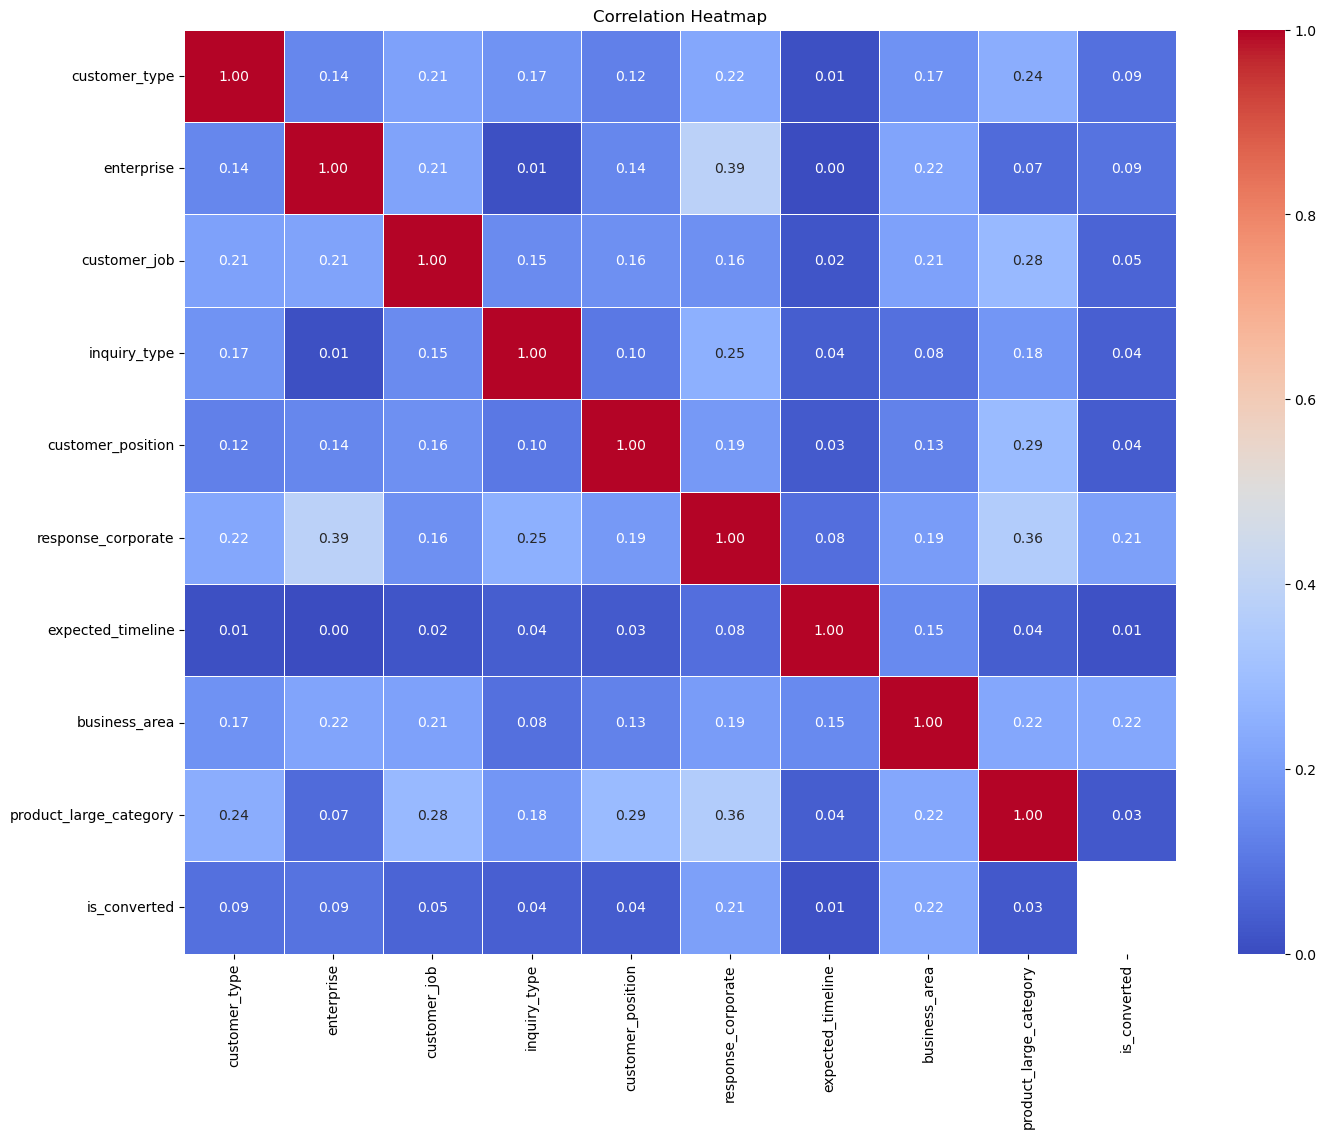

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# "object" 타입의 변수 선택
object_variables = df_train.select_dtypes(include=['object']).columns

# Cramer's V 계산 함수
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 선택한 "object" 변수들 간의 상관계수 계산
correlation_matrix = pd.DataFrame(index=object_variables, columns=object_variables)

for var1 in object_variables:
    for var2 in object_variables:
        correlation_matrix.loc[var1, var2] = pd.to_numeric(cramers_v(df_train[var1], df_train[var2]), errors='coerce')

# 'is_converted'와 다른 'object' 변수 간의 상관계수 계산
for var in object_variables:
    correlation_matrix.loc['is_converted', var] = pd.to_numeric(cramers_v(df_train['is_converted'], df_train[var]), errors='coerce')
    correlation_matrix.loc[var, 'is_converted'] = pd.to_numeric(cramers_v(df_train[var], df_train['is_converted']), errors='coerce')

# 결과 출력
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

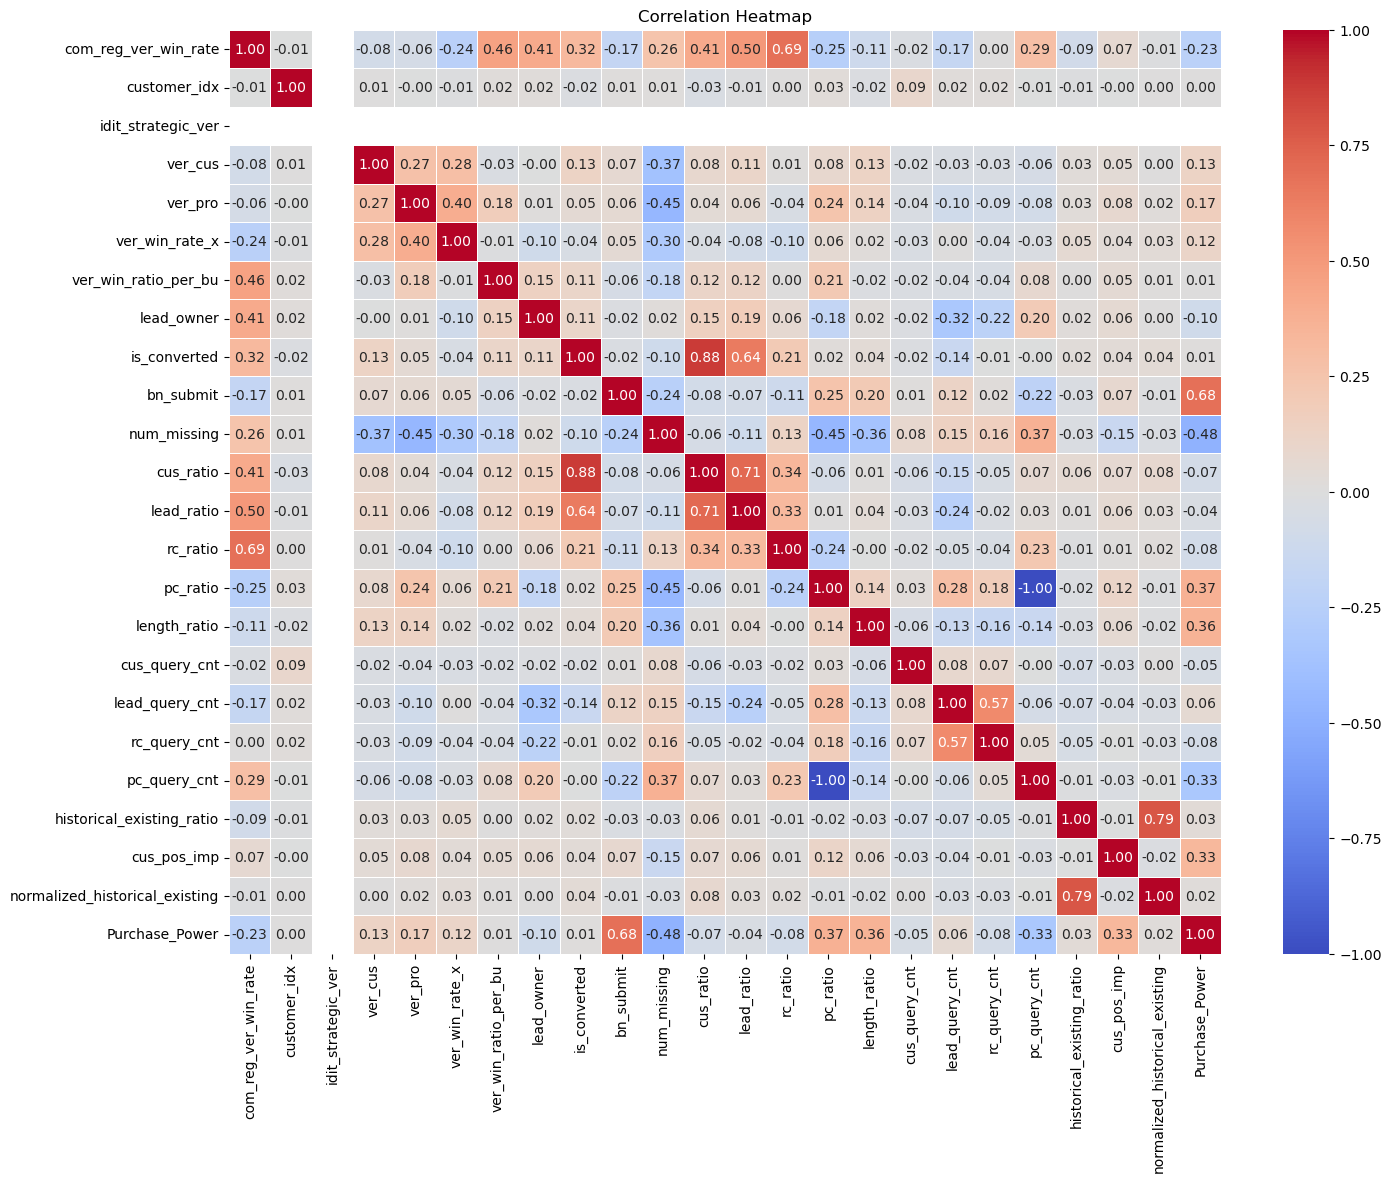

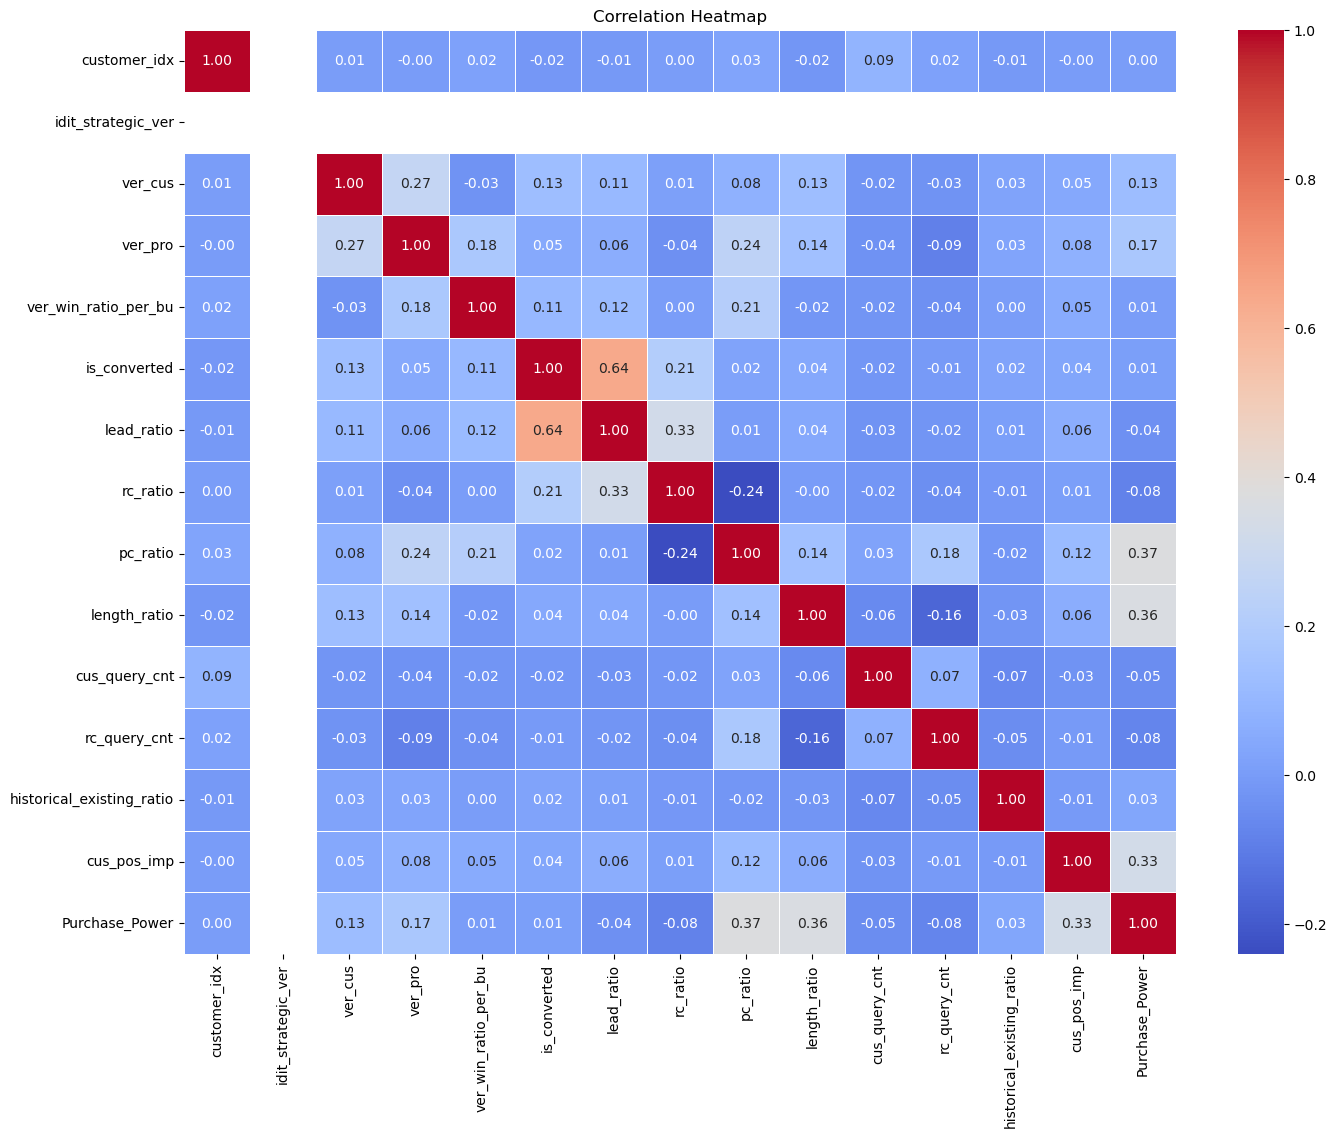

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

# 상관계수 행렬
correlation_matrix = df_train[df_train.select_dtypes(include = ['float64', 'int64']).columns].corr()

# 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

drop_cols=['com_reg_ver_win_rate', 'lead_owner', 'cus_ratio', 'lead_query_cnt', 'num_missing', 'ver_win_rate_x', 'normalized_historical_existing', 
            'bn_submit',
           'pc_query_cnt']
for col in drop_cols:
    if col in df_train.columns:
        df_train.drop(columns = col, axis = 1, inplace = True)
        df_test.drop(columns = col, axis = 1, inplace = True)
correlation_matrix = df_train[df_train.select_dtypes(include = ['float64', 'int64']).columns].corr()

# 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

### 5.2 결측치

In [51]:
df_train.isnull().sum().sum()

233822

In [52]:
df_test= df_test.drop(["id"], axis=1)

In [53]:
print(df_train.shape, df_test.shape)

(45268, 24) (5271, 24)


In [54]:
X_train= df_train.drop("is_converted", axis=1)
y_train= df_train["is_converted"].astype('bool')
X_test = df_test.drop(["is_converted"], axis=1)

In [55]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [56]:
y_train.value_counts()

is_converted
False    43138
True      2130
Name: count, dtype: int64

In [57]:
nullzero_cols=['idit_strategic_ver', 'historical_existing_ratio', 'cus_pos_imp', 'ver_win_ratio_per_bu']
X_train[nullzero_cols]=X_train[nullzero_cols].fillna(0)
X_test[nullzero_cols]=X_test[nullzero_cols].fillna(0)

In [58]:
X_train.isnull().sum()

customer_idx                     0
customer_type                32544
enterprise                       0
idit_strategic_ver               0
customer_job                     0
inquiry_type                     0
customer_position                0
response_corporate               0
expected_timeline            29239
ver_cus                          0
ver_pro                          0
ver_win_ratio_per_bu             0
business_area                28503
product_large_category           0
lead_ratio                     262
rc_ratio                       458
pc_ratio                     11108
length_ratio                     0
cus_query_cnt                    0
rc_query_cnt                     0
historical_existing_ratio        0
cus_pos_imp                      0
Purchase_Power                   0
dtype: int64

In [59]:
import random
import numpy as np
import os

# 기본 Python 난수 시드 설정
random.seed(0)

# NumPy 난수 시드 설정
np.random.seed(0)

# 일부 환경에서 동시성이 있는 작업을 위한 OS 환경변수 설정
os.environ['PYTHONHASHSEED'] = str(0)

In [60]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45268 entries, 0 to 45267
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_idx               45268 non-null  int64  
 1   customer_type              12724 non-null  object 
 2   enterprise                 45268 non-null  object 
 3   idit_strategic_ver         45268 non-null  float64
 4   customer_job               45268 non-null  object 
 5   inquiry_type               45268 non-null  object 
 6   customer_position          45268 non-null  object 
 7   response_corporate         45268 non-null  object 
 8   expected_timeline          16029 non-null  object 
 9   ver_cus                    45268 non-null  int64  
 10  ver_pro                    45268 non-null  int64  
 11  ver_win_ratio_per_bu       45268 non-null  float64
 12  business_area              16765 non-null  object 
 13  product_large_category     45268 non-null  obj

In [61]:
object_columns = X_train.select_dtypes(include=['object']).columns
object_columns

Index(['customer_type', 'enterprise', 'customer_job', 'inquiry_type',
       'customer_position', 'response_corporate', 'expected_timeline',
       'business_area', 'product_large_category'],
      dtype='object')

In [62]:
import numpy as np
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, early_stopping

X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
object_columns = X_train_cat.select_dtypes(include=['object']).columns
cat_cols=list(object_columns)
cat_cols.extend(['customer_idx', 'idit_strategic_ver', 'ver_cus', 'ver_pro', 'cus_pos_imp'])
for col in cat_cols:
    X_train_cat[col] = X_train_cat[col].astype('category')
    X_test_cat[col] = X_test_cat[col].astype('category')
    
# # Optuna의 로그 출력을 비활성화합니다.
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# def objective(trial):
#     param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 30, 300),
#         'max_depth': trial.suggest_int('max_depth', 6, 16),
#         'subsample': trial.suggest_float('subsample', 0.6, 0.9),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 10.0, log=True),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
#         'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True),
#         'min_split_gain': trial.suggest_float('min_split_gain', 0.01, 0.1),
#         'random_state': 0,
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 3, 5),
#         'categorical_feature': cat_cols,
#         'n_jobs': -1
#     }

#     f1_scores = []
#     threshold = 0.5

#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#     for train_index, test_index in kf.split(X_train_cat, y_train):
#         X_tr_op, X_val_op = X_train_cat.iloc[train_index], X_train_cat.iloc[test_index]
#         y_tr_op, y_val_op = y_train.iloc[train_index], y_train.iloc[test_index]

#         lgb_model = LGBMClassifier(**param)
#         # early_stopping 콜백의 verbose_eval 옵션을 False로 설정하여 출력을 제거합니다.
#         lgb_model.fit(X_tr_op, y_tr_op, eval_set=[(X_val_op, y_val_op)], callbacks=[early_stopping(200, verbose=0)])

#         preds_proba = lgb_model.predict_proba(X_val_op)[:, 1]
#         preds = (preds_proba > threshold).astype(int)

#         f1 = f1_score(y_val_op, preds)
#         f1_scores.append(f1)

#     return np.mean(f1_scores)

# sampler=TPESampler(seed=0)
# study1 = optuna.create_study(direction='maximize', sampler=sampler)
# study1.optimize(objective, n_trials=50, n_jobs=-1)

# # 최종 결과만 출력합니다.
# print('Best f1:', study1.best_value)
# print('Best trial:', study1.best_trial.params)

In [63]:
lgbm_params= {'learning_rate': 0.085, 'num_leaves': 100, 'max_depth': 15, 'subsample': 0.75, 'colsample_bytree': 0.75, 'lambda_l1': 0.2, 'lambda_l2': 0.2, 'min_child_samples': 6,
              'min_child_weight': 0.1, 'min_split_gain': 0.05, 'scale_pos_weight': 3.0, 'objective': 'binary', 'metric': 'binary_logloss', 'boosting_type': 'gbdt','categorical_feature': cat_cols,
              'n_jobs': -1} 

In [64]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping
from sklearn.metrics import f1_score
import numpy as np

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_lgb_val_preds = np.zeros(X_train_cat.shape[0])
oof_lgb_test_preds = np.zeros(X_test_cat.shape[0])

params = lgbm_params

f1_score_lgb_list = []

random_seeds = [0, 2, 4, 8, 16]
for seed in random_seeds:
    for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train_cat, y_train)):
        print('#'*40, f'폴드{idx+1} / 폴드{folds.n_splits}', "#"*40)
        X_tr, y_tr = X_train_cat.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train_cat.iloc[valid_idx], y_train.iloc[valid_idx]
        lgb_model = LGBMClassifier(**params, random_state=seed, verbosity=-1)
        lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='f1', callbacks=[early_stopping(stopping_rounds=200, verbose=0)])

        oof_lgb_test_preds += lgb_model.predict_proba(X_test_cat)[:, 1] / (folds.n_splits * len(random_seeds))
        oof_lgb_val_preds[valid_idx] += lgb_model.predict(X_val) / len(random_seeds)  # 클래스에 대한 예측값으로 수정

        f1 = f1_score(y_val, np.where(oof_lgb_val_preds[valid_idx] > 0.5, 1, 0))
        f1_score_lgb_list.append(f1)
        print(f'폴드 {idx+1} f1 score: {f1}\n')


    print(f'검증 평균 f1 score: {np.mean(f1_score_lgb_list)}')
    
oof_lgb_test_preds = oof_lgb_test_preds / len(random_seeds)
print(oof_lgb_test_preds.mean())

######################################## 폴드1 / 폴드5 ########################################
폴드 1 f1 score: 0.0

######################################## 폴드2 / 폴드5 ########################################
폴드 2 f1 score: 0.0

######################################## 폴드3 / 폴드5 ########################################
폴드 3 f1 score: 0.0

######################################## 폴드4 / 폴드5 ########################################
폴드 4 f1 score: 0.0

######################################## 폴드5 / 폴드5 ########################################
폴드 5 f1 score: 0.0

검증 평균 f1 score: 0.0
######################################## 폴드1 / 폴드5 ########################################
폴드 1 f1 score: 0.0

######################################## 폴드2 / 폴드5 ########################################
폴드 2 f1 score: 0.0

######################################## 폴드3 / 폴드5 ########################################
폴드 3 f1 score: 0.0

######################################## 폴드4 / 폴드5 #################################

In [65]:
cat_cols

['customer_type',
 'enterprise',
 'customer_job',
 'inquiry_type',
 'customer_position',
 'response_corporate',
 'expected_timeline',
 'business_area',
 'product_large_category',
 'customer_idx',
 'idit_strategic_ver',
 'ver_cus',
 'ver_pro',
 'cus_pos_imp']

In [66]:
import numpy as np
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool

# CatBoost는 범주형 변수를 자동으로 처리할 수 있으므로 별도의 데이터 타입 변경이 필요 없습니다.
# 범주형 변수를 문자열로 변환하고, NaN 값을 'missing'으로 대체

X_train_cat2 = X_train.copy()
X_test_cat2 = X_test.copy()

for col in cat_cols:
    X_train_cat2[col] = X_train_cat2[col].astype(str).fillna(-1)
    X_test_cat2[col] = X_test_cat2[col].astype(str).fillna(-1)


# Optuna의 로그 출력을 비활성화합니다.
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    param = {
        'objective': 'Logloss',  # Objective function for binary classification
        'eval_metric': 'Logloss',  # Metric for evaluation
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # Adjust learning rate
        'depth': trial.suggest_int('depth', 6, 16),  # Depth of trees
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),  # L2 regularization term
        'border_count': trial.suggest_int('border_count', 50, 200),  # Number of splits for numerical features
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),  # Bagging temperature for Bayesian bootstrap
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Random strength for scoring splits
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),  # Minimum sum of instance weight needed in a leaf
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),  # Number of steps in the gradient descent
        'bootstrap_type': 'Bayesian',  # Bootstrap type
        'random_seed': 0,  # Random seed for reproducibility
        'verbose': False,  # Turn off verbose output
        'thread_count': -1  # Use all available threads
    }

    f1_scores = []
    threshold = 0.5

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    for train_index, test_index in kf.split(X_train_cat2, y_train):
        X_tr_op, X_val_op = X_train_cat2.iloc[train_index], X_train_cat2.iloc[test_index]
        y_tr_op, y_val_op = y_train.iloc[train_index], y_train.iloc[test_index]

        train_pool = Pool(X_tr_op, y_tr_op, cat_features=cat_cols)
        validate_pool = Pool(X_val_op, y_val_op, cat_features=cat_cols)

        model = CatBoostClassifier(**param)
        model.fit(train_pool, eval_set=validate_pool, early_stopping_rounds=200)

        preds_proba = model.predict_proba(validate_pool)[:, 1]
        preds = (preds_proba > threshold).astype(int)

        f1 = f1_score(y_val_op, preds)
        f1_scores.append(f1)

    return np.mean(f1_scores)

sampler = TPESampler(seed=0)
study2 = optuna.create_study(direction='maximize', sampler=sampler)
study2.optimize(objective, n_trials=50, n_jobs=-1)

# 최종 결과만 출력합니다.
print('Best f1:', study2.best_value)
print('Best trial:', study2.best_trial.params)


In [75]:
cat_params= {'learning_rate': 0.04902330357228418, 'depth': 10, 
             'l2_leaf_reg': 6.735831203098586, 
             'border_count': 147, 'bagging_temperature': 0.6098151627228174, 'random_strength': 4.321133788510857,
             'min_data_in_leaf': 28, 'leaf_estimation_iterations': 10,
                     'objective': 'Logloss',  # Objective function for binary classification
        'eval_metric': 'F1', 'loss_function' : 'Logloss', 'thread_count': -1, 'bootstrap_type': 'Bayesian'
        }

In [100]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# 가정: X_train_cat2, X_test_cat2, y_train 정의됨, cat_params 정의됨

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_cat_val_preds = np.zeros(X_train_cat2.shape[0])
oof_cat_test_preds = np.zeros(X_test_cat2.shape[0])

params = cat_params  # CatBoost 파라미터

random_seeds = [0]
for seed in random_seeds:
    f1_score_cat_list = []  # 각 시드별로 F1 스코어를 저장할 리스트 초기화
    for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train_cat2, y_train)):
        print('#' * 40, f'폴드 {idx + 1} / 폴드 {folds.n_splits}', '#' * 40)
        X_tr, y_tr = X_train_cat2.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train_cat2.iloc[valid_idx], y_train.iloc[valid_idx]
        
        cat_model = CatBoostClassifier(**params, random_seed=seed, verbose=0, cat_features=cat_cols)
        cat_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100)

        oof_cat_test_preds += cat_model.predict_proba(X_test_cat2)[:, 1] / (folds.n_splits * len(random_seeds))
        oof_cat_val_preds[valid_idx] += cat_model.predict_proba(X_val)[:, 1] / len(random_seeds)

        f1 = f1_score(y_val, np.where(oof_cat_val_preds[valid_idx] > 0.5, 1, 0))
        f1_score_cat_list.append(f1)
        print(f'폴드 {idx + 1} F1 스코어: {f1}\n')

    print(f'검증 평균 F1 스코어: {np.mean(f1_score_cat_list)}\n')
    
oof_cat_test_preds = oof_cat_test_preds / len(random_seeds)  # 시드 개수로 나누어야 함
# 최종 테스트 예측값의 평균을 취함
print(f'테스트 세트 예측값 평균: {oof_cat_test_preds.mean()}')

######################################## 폴드 1 / 폴드 5 ########################################
폴드 1 F1 스코어: 0.679296346414073

######################################## 폴드 2 / 폴드 5 ########################################
폴드 2 F1 스코어: 0.6648648648648648

######################################## 폴드 3 / 폴드 5 ########################################
폴드 3 F1 스코어: 0.6484268125854994

######################################## 폴드 4 / 폴드 5 ########################################
폴드 4 F1 스코어: 0.6967213114754098

######################################## 폴드 5 / 폴드 5 ########################################
폴드 5 F1 스코어: 0.6323119777158774

검증 평균 F1 스코어: 0.664324262611145

테스트 세트 예측값 평균: 0.17270975603781477


In [77]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [85]:
def encoding(df) :
    # 레이블 인코딩할 칼럼들
    label_columns = [# 'business_unit',
                     # 'customer_type',
                     # 'enterprise',
                     # 'customer_job',
                     # 'inquiry_type',
                     # 'customer_position',
                     'response_corporate',
                     # 'product_large_category',
    ]

    # 인코딩할 칼럼들
    one_hot_columns=[
                     'customer_type',
                     'enterprise',
                     'customer_job',
                     'inquiry_type',
                     'customer_position',
                     'expected_timeline',
                     'business_area',
                     'product_large_category',
    ]

    for col in label_columns:
        if col in df.columns:
            df[col] = label_encoding(df[col])
        else:
            print(col)
    print("")
    one_hot_real_columns = one_hot_columns.copy()

    for col in one_hot_columns:
        if col not in df.columns:
            one_hot_real_columns.remove(col)
            print(col)
    df = pd.get_dummies(df, columns=one_hot_real_columns)

    return df

X_train_enco = encoding(X_train.copy())
X_test_enco = encoding(X_test.copy())

In [86]:
for col in X_test_enco.columns:
    if col not in X_train_enco.columns:
        X_train_enco[col] = 0
        print(col)

customer_position_vice president


In [87]:
for col in X_train_enco.columns:
    if col not in X_test_enco.columns:
        X_test_enco[col] = 0
        print(col)

In [88]:
X_test_enco = X_test_enco[X_train_enco.columns]

In [89]:
xgb_params= {'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.84, 'reg_lambda': 0.02, 'reg_alpha': 0.02, 
             'min_child_weight': 1.6, 'scale_pos_weight': 3.0,         'objective': 'binary:logistic',
        'use_label_encoder': False,
        'eval_metric': 'logloss', 'n_jobs': -1}

In [90]:
X_train_enco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45268 entries, 0 to 45267
Data columns (total 71 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   customer_idx                                     45268 non-null  int64  
 1   idit_strategic_ver                               45268 non-null  float64
 2   response_corporate                               45268 non-null  int64  
 3   ver_cus                                          45268 non-null  int64  
 4   ver_pro                                          45268 non-null  int64  
 5   ver_win_ratio_per_bu                             45268 non-null  float64
 6   lead_ratio                                       45006 non-null  float64
 7   rc_ratio                                         44810 non-null  float64
 8   pc_ratio                                         34160 non-null  float64
 9   length_ratio                

In [91]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Assuming X_train_enco, X_test_enco, y_train are defined, and xgb_params is defined

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_xgb_val_preds = np.zeros(X_train_enco.shape[0])
oof_xgb_test_preds = np.zeros(X_test_enco.shape[0])

params =  xgb_params  # XGBoost parameters

f1_score_xgb_list = []

random_seeds = [0, 2, 4, 8, 16]
for seed in random_seeds:
    for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train_enco, y_train)):
        print('#' * 40, f'폴드 {idx + 1} / 폴드 {folds.n_splits}', '#' * 40)
        X_tr, y_tr = X_train_enco.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train_enco.iloc[valid_idx], y_train.iloc[valid_idx]
        
        xgb_model = XGBClassifier(**params, random_state=seed, verbosity=0)
        xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=200)

        oof_xgb_test_preds += xgb_model.predict_proba(X_test_enco)[:, 1] / (folds.n_splits * len(random_seeds))
        oof_xgb_val_preds[valid_idx] += xgb_model.predict_proba(X_val)[:, 1] / len(random_seeds)

        f1 = f1_score(y_val, np.where(oof_xgb_val_preds[valid_idx] > 0.1, 1, 0))
        f1_score_xgb_list.append(f1)
        print(f'폴드 {idx + 1} F1 스코어: {f1}\n')

print(f'검증 평균 F1 스코어: {np.mean(f1_score_xgb_list)}\n')
    
oof_xgb_test_preds = oof_xgb_test_preds/5
# Take the mean of final test predictions
print(f'테스트 세트 예측값 평균: {oof_xgb_test_preds.mean()}')

######################################## 폴드 1 / 폴드 5 ########################################
[0]	validation_0-logloss:0.26022
[1]	validation_0-logloss:0.24816
[2]	validation_0-logloss:0.23714
[3]	validation_0-logloss:0.22995
[4]	validation_0-logloss:0.22050
[5]	validation_0-logloss:0.21207
[6]	validation_0-logloss:0.20429
[7]	validation_0-logloss:0.19648
[8]	validation_0-logloss:0.18951
[9]	validation_0-logloss:0.18448
[10]	validation_0-logloss:0.17824
[11]	validation_0-logloss:0.17240
[12]	validation_0-logloss:0.16810
[13]	validation_0-logloss:0.16306
[14]	validation_0-logloss:0.15816
[15]	validation_0-logloss:0.15339
[16]	validation_0-logloss:0.14914
[17]	validation_0-logloss:0.14507
[18]	validation_0-logloss:0.14112
[19]	validation_0-logloss:0.13737
[20]	validation_0-logloss:0.13393
[21]	validation_0-logloss:0.13075
[22]	validation_0-logloss:0.12832
[23]	validation_0-logloss:0.12526
[24]	validation_0-logloss:0.12265
[25]	validation_0-logloss:0.12070
[26]	validation_0-logloss:0.1182

In [96]:
rb_params= {'n_estimators': 948, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1, 
            'max_features': 'auto', 'bootstrap': False, 'class_weight': None, 'n_jobs': -1}

In [97]:
X_train_enco = X_train_enco.fillna(-1)
X_test_enco = X_test_enco.fillna(-1)

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import numpy as np

# Assuming X_train_enco, X_test_enco, y_train are defined

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

oof_rf_val_preds = np.zeros(X_train_enco.shape[0])
oof_rf_test_preds = np.zeros(X_test_enco.shape[0])

# Adjust parameters for RandomForest
# For example purposes, let's assume 'study.best_trial.params' was used for XGB and now needs to be adapted.
# XGBoost specific params should be replaced or removed. Here we define some common RandomForest parameters.
params = rb_params

f1_score_rf_list = []

random_seeds =[8, 16]
for seed in random_seeds:
    for idx, (train_idx, valid_idx) in enumerate(folds.split(X_train_enco, y_train)):
        print('#' * 40, f'Fold {idx + 1} / {folds.n_splits}', '#' * 40)
        X_tr, y_tr = X_train_enco.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train_enco.iloc[valid_idx], y_train.iloc[valid_idx]
        
        rf_model = RandomForestClassifier(**params, random_state=seed)
        rf_model.fit(X_tr, y_tr)

        oof_rf_test_preds += rf_model.predict_proba(X_test_enco)[:, 1] / (folds.n_splits * len(random_seeds))
        oof_rf_val_preds[valid_idx] += rf_model.predict_proba(X_val)[:, 1] / len(random_seeds)

        f1 = f1_score(y_val, np.where(oof_rf_val_preds[valid_idx] > 0.5, 1, 0))  # Adjusted threshold to 0.5, common for binary classification
        f1_score_rf_list.append(f1)
        print(f'Fold {idx + 1} F1 score: {f1}\n')

print(f'Validation average F1 score: {np.mean(f1_score_rf_list)}\n')

# Average the final test predictions
oof_rf_test_preds = oof_rf_test_preds / 5
print(f'Test set prediction average: {oof_rf_test_preds.mean()}')

######################################## Fold 1 / 5 ########################################
Fold 1 F1 score: 0.0

######################################## Fold 2 / 5 ########################################
Fold 2 F1 score: 0.0

######################################## Fold 3 / 5 ########################################
Fold 3 F1 score: 0.0

######################################## Fold 4 / 5 ########################################
Fold 4 F1 score: 0.0

######################################## Fold 5 / 5 ########################################
Fold 5 F1 score: 0.0

######################################## Fold 1 / 5 ########################################
Fold 1 F1 score: 0.0

######################################## Fold 2 / 5 ########################################
Fold 2 F1 score: 0.0

######################################## Fold 3 / 5 ########################################
Fold 3 F1 score: 0.0

######################################## Fold 4 / 5 ############################

In [131]:
# 예측에 필요한 데이터 분리
oof_test_preds = oof_lgb_test_preds*0.05 + oof_cat_test_preds*0.85+ oof_xgb_test_preds*0.05 + oof_rf_test_preds*0.05
test_pred = np.where(oof_test_preds >= 0.05, 1, 0)

In [132]:
sum(test_pred)

2216

In [133]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"]=test_pred
df_sub["is_converted"].value_counts()

is_converted
0    3055
1    2216
Name: count, dtype: int64

In [134]:
# 제출 파일 저장
df_sub.to_csv("submission_final.csv", index=False)

In [135]:
df_sub.head()

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,1
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,1
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,1
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,0
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,1
